In [2]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [3]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-05 03:48:38,721] A new study created in memory with name: no-name-ef813ee5-d9e4-435d-9bf7-1859be6098e8
[I 2025-06-05 03:50:48,737] Trial 0 finished with value: 0.504646611213684 and parameters: {'lr': 0.0015368380632845018, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2838226817618247}. Best is trial 0 with value: 0.504646611213684.


Cross Validation Accuracies:
[0.47883012890815735, 0.4905443489551544, 0.5034693479537964, 0.5299490094184875, 0.5204402208328247]
Mean Cross Validation Accuracy:
0.504646611213684
Standard Deviation of Cross Validation Accuracy:
0.018742464981636002


[I 2025-06-05 03:53:47,187] Trial 1 finished with value: 0.09163663536310196 and parameters: {'lr': 0.0020605025933886924, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12773345437507233}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.11642837524414062, 0.08817285299301147, 0.07738424837589264, 0.10536589473485947, 0.07083180546760559]
Mean Cross Validation Accuracy:
0.09163663536310196
Standard Deviation of Cross Validation Accuracy:
0.01703579877403544


[I 2025-06-05 03:55:59,578] Trial 2 finished with value: 0.09493317604064941 and parameters: {'lr': 0.033629687104614885, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3061902304749753}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.12009371072053909, 0.0941850021481514, 0.07894223928451538, 0.10574063658714294, 0.07570429146289825]
Mean Cross Validation Accuracy:
0.09493317604064941
Standard Deviation of Cross Validation Accuracy:
0.016588390720371375


[I 2025-06-05 03:58:16,946] Trial 3 finished with value: 0.10540333092212677 and parameters: {'lr': 0.19129352378263975, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.22587150701956618}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.11406820267438889, 0.11141917109489441, 0.10046128183603287, 0.1099986806511879, 0.09106931835412979]
Mean Cross Validation Accuracy:
0.10540333092212677
Standard Deviation of Cross Validation Accuracy:
0.00851205427694953


[I 2025-06-05 04:00:12,501] Trial 4 finished with value: 0.11235470026731491 and parameters: {'lr': 0.15063131760976264, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1494965396573496}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.14154614508152008, 0.11394515633583069, 0.09010195732116699, 0.1230114996433258, 0.09316874295473099]
Mean Cross Validation Accuracy:
0.11235470026731491
Standard Deviation of Cross Validation Accuracy:
0.019139085142267587


[I 2025-06-05 04:03:45,786] Trial 5 finished with value: 0.11154200732707978 and parameters: {'lr': 0.007287879199971694, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1565892330443017}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.13300108909606934, 0.0858696848154068, 0.10857242345809937, 0.1145310327410698, 0.11573580652475357]
Mean Cross Validation Accuracy:
0.11154200732707978
Standard Deviation of Cross Validation Accuracy:
0.015198032678622108


[I 2025-06-05 04:07:46,846] Trial 6 finished with value: 0.1503744512796402 and parameters: {'lr': 0.001863533184654423, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4272007324815953}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.17703652381896973, 0.15350577235221863, 0.1566876322031021, 0.14977765083312988, 0.11486467719078064]
Mean Cross Validation Accuracy:
0.1503744512796402
Standard Deviation of Cross Validation Accuracy:
0.020108842650631106


[I 2025-06-05 04:11:13,017] Trial 7 finished with value: 0.11071751415729522 and parameters: {'lr': 0.4366708443607091, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2749467293604796}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.13230934739112854, 0.10202320665121078, 0.0881614238023758, 0.1250421404838562, 0.10605145245790482]
Mean Cross Validation Accuracy:
0.11071751415729522
Standard Deviation of Cross Validation Accuracy:
0.01598463330005062


[I 2025-06-05 04:15:02,427] Trial 8 finished with value: 1.3803662061691284 and parameters: {'lr': 0.021022460580015376, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.20104131623354574}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[1.4646224975585938, 1.0145399570465088, 1.742411732673645, 1.5276873111724854, 1.1525695323944092]
Mean Cross Validation Accuracy:
1.3803662061691284
Standard Deviation of Cross Validation Accuracy:
0.26290673746026366


[I 2025-06-05 04:18:47,532] Trial 9 finished with value: 0.11517874896526337 and parameters: {'lr': 0.0010599588518157479, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3038938684113407}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.11078906804323196, 0.13084419071674347, 0.11148044466972351, 0.10610504448413849, 0.1166749969124794]
Mean Cross Validation Accuracy:
0.11517874896526337
Standard Deviation of Cross Validation Accuracy:
0.008519667710175144


[I 2025-06-05 04:21:13,454] Trial 10 finished with value: 0.09352166205644608 and parameters: {'lr': 0.006434757153903445, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.48222226183630895}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.11472433805465698, 0.10510923713445663, 0.07323600351810455, 0.10676360130310059, 0.06777513027191162]
Mean Cross Validation Accuracy:
0.09352166205644608
Standard Deviation of Cross Validation Accuracy:
0.019149758024330023


[I 2025-06-05 04:24:06,264] Trial 11 finished with value: 0.0977338433265686 and parameters: {'lr': 0.005903428498995448, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4817306391209395}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.13574378192424774, 0.09535907953977585, 0.07459106296300888, 0.1154007539153099, 0.06757453829050064]
Mean Cross Validation Accuracy:
0.0977338433265686
Standard Deviation of Cross Validation Accuracy:
0.02532858712288366


[I 2025-06-05 04:26:23,659] Trial 12 finished with value: 0.09323336482048035 and parameters: {'lr': 0.005497108456345841, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38506681174119206}. Best is trial 1 with value: 0.09163663536310196.


Cross Validation Accuracies:
[0.12135561555624008, 0.0901985764503479, 0.0753590390086174, 0.10415036976337433, 0.07510322332382202]
Mean Cross Validation Accuracy:
0.09323336482048035
Standard Deviation of Cross Validation Accuracy:
0.01770562327475135


[I 2025-06-05 04:28:54,681] Trial 13 finished with value: 0.09099026620388032 and parameters: {'lr': 0.01869805264740105, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38040377507455914}. Best is trial 13 with value: 0.09099026620388032.


Cross Validation Accuracies:
[0.11457467824220657, 0.09202491492033005, 0.076230488717556, 0.10419463366270065, 0.06792661547660828]
Mean Cross Validation Accuracy:
0.09099026620388032
Standard Deviation of Cross Validation Accuracy:
0.017212979553017285


[I 2025-06-05 04:30:58,078] Trial 14 finished with value: 0.09259092807769775 and parameters: {'lr': 0.04032993145400347, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3668356951005446}. Best is trial 13 with value: 0.09099026620388032.


Cross Validation Accuracies:
[0.1215556263923645, 0.08983471989631653, 0.07413993775844574, 0.10505311191082001, 0.07237124443054199]
Mean Cross Validation Accuracy:
0.09259092807769775
Standard Deviation of Cross Validation Accuracy:
0.018714331986162343


[I 2025-06-05 04:33:30,371] Trial 15 finished with value: 0.08954262137413024 and parameters: {'lr': 0.01549700207196854, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11304672686370537}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11426769196987152, 0.09042348712682724, 0.07183174788951874, 0.10499130189418793, 0.06619887799024582]
Mean Cross Validation Accuracy:
0.08954262137413024
Standard Deviation of Cross Validation Accuracy:
0.018489846754421935


[I 2025-06-05 04:36:08,072] Trial 16 finished with value: 0.40383607149124146 and parameters: {'lr': 0.0158997324738904, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10089832780335822}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.3729093074798584, 0.39875322580337524, 0.44876256585121155, 0.3806890845298767, 0.4180661737918854]
Mean Cross Validation Accuracy:
0.40383607149124146
Standard Deviation of Cross Validation Accuracy:
0.02734581783328209


[I 2025-06-05 04:38:43,610] Trial 17 finished with value: 0.2427394688129425 and parameters: {'lr': 0.0862909015087077, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.36112692514878275}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.15890415012836456, 0.30689212679862976, 0.18776310980319977, 0.2931797504425049, 0.26695820689201355]
Mean Cross Validation Accuracy:
0.2427394688129425
Standard Deviation of Cross Validation Accuracy:
0.05881682330856307


[I 2025-06-05 04:41:00,963] Trial 18 finished with value: 0.09081302285194397 and parameters: {'lr': 0.060544012661091356, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.42454986360657676}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11419759690761566, 0.09164686501026154, 0.07529252767562866, 0.10443886369466782, 0.06848926097154617]
Mean Cross Validation Accuracy:
0.09081302285194397
Standard Deviation of Cross Validation Accuracy:
0.01716061333514715


[I 2025-06-05 04:43:04,522] Trial 19 finished with value: 0.09075767248868942 and parameters: {'lr': 0.06172079541583582, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43984896974815135}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.1143176481127739, 0.09029792249202728, 0.07510604709386826, 0.10604676604270935, 0.06801997870206833]
Mean Cross Validation Accuracy:
0.09075767248868942
Standard Deviation of Cross Validation Accuracy:
0.01761258810853429


[I 2025-06-05 04:45:24,543] Trial 20 finished with value: 0.36697357296943667 and parameters: {'lr': 0.666398791451698, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22031019700002652}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.4706040620803833, 0.3342984616756439, 0.32732072472572327, 0.3519311845302582, 0.35071343183517456]
Mean Cross Validation Accuracy:
0.36697357296943667
Standard Deviation of Cross Validation Accuracy:
0.05266869124050072


[I 2025-06-05 04:47:41,194] Trial 21 finished with value: 0.09072345793247223 and parameters: {'lr': 0.06953048096826406, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43427681251540856}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11259724199771881, 0.08874601125717163, 0.07340538501739502, 0.10553533583879471, 0.07333331555128098]
Mean Cross Validation Accuracy:
0.09072345793247223
Standard Deviation of Cross Validation Accuracy:
0.01614990497389091


[I 2025-06-05 04:49:54,861] Trial 22 finished with value: 0.09023525565862656 and parameters: {'lr': 0.11539327137994859, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4327553379731925}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11470195651054382, 0.0880049467086792, 0.0738377645611763, 0.10588223487138748, 0.06874937564134598]
Mean Cross Validation Accuracy:
0.09023525565862656
Standard Deviation of Cross Validation Accuracy:
0.017770438607315996


[I 2025-06-05 04:51:58,064] Trial 23 finished with value: 0.09063048213720322 and parameters: {'lr': 0.10137041263147274, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3407642006612016}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11318720877170563, 0.09042253345251083, 0.07593493908643723, 0.10506219416856766, 0.06854553520679474]
Mean Cross Validation Accuracy:
0.09063048213720322
Standard Deviation of Cross Validation Accuracy:
0.016857208177816635


[I 2025-06-05 04:54:02,438] Trial 24 finished with value: 0.09082726240158082 and parameters: {'lr': 0.21759274575621698, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33408529499344286}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.1149221658706665, 0.08946732431650162, 0.0748506560921669, 0.1056111678481102, 0.06928499788045883]
Mean Cross Validation Accuracy:
0.09082726240158082
Standard Deviation of Cross Validation Accuracy:
0.017437309281513148


[I 2025-06-05 04:56:09,991] Trial 25 finished with value: 0.09035417139530182 and parameters: {'lr': 0.1212987347704459, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3348728769171794}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11300456523895264, 0.08933502435684204, 0.07497124373912811, 0.10515887290239334, 0.06930115073919296]
Mean Cross Validation Accuracy:
0.09035417139530182
Standard Deviation of Cross Validation Accuracy:
0.016811438550547626


[I 2025-06-05 04:58:19,301] Trial 26 finished with value: 0.10274490416049957 and parameters: {'lr': 0.2802447840675369, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18620250317213824}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11371924728155136, 0.10448567569255829, 0.07434111088514328, 0.11518604308366776, 0.10599244385957718]
Mean Cross Validation Accuracy:
0.10274490416049957
Standard Deviation of Cross Validation Accuracy:
0.014802502603933117


[I 2025-06-05 05:00:48,301] Trial 27 finished with value: 0.09208524078130723 and parameters: {'lr': 0.8559249129513018, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4000697051547156}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11627933382987976, 0.09226113557815552, 0.07817349582910538, 0.10362573713064194, 0.07008650153875351]
Mean Cross Validation Accuracy:
0.09208524078130723
Standard Deviation of Cross Validation Accuracy:
0.01670957395799509


[I 2025-06-05 05:03:25,720] Trial 28 finished with value: 0.15484917312860488 and parameters: {'lr': 0.010857316006214828, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2529592919087009}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.12306486070156097, 0.1397545486688614, 0.08522889763116837, 0.19144074618816376, 0.23475681245326996]
Mean Cross Validation Accuracy:
0.15484917312860488
Standard Deviation of Cross Validation Accuracy:
0.052553300573405244


[I 2025-06-05 05:05:49,086] Trial 29 finished with value: 0.09412216395139694 and parameters: {'lr': 0.13243502562762496, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2586922244674087}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.11617689579725266, 0.09295731037855148, 0.07075602561235428, 0.1050298810005188, 0.0856907069683075]
Mean Cross Validation Accuracy:
0.09412216395139694
Standard Deviation of Cross Validation Accuracy:
0.01564488580718596


[I 2025-06-05 05:08:09,729] Trial 30 finished with value: 0.09332715719938278 and parameters: {'lr': 0.3391821481836916, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4572003425700874}. Best is trial 15 with value: 0.08954262137413024.


Cross Validation Accuracies:
[0.121524378657341, 0.09380779415369034, 0.0825754851102829, 0.10418183356523514, 0.06454629451036453]
Mean Cross Validation Accuracy:
0.09332715719938278
Standard Deviation of Cross Validation Accuracy:
0.019272129195675457


[I 2025-06-05 05:10:19,934] Trial 31 finished with value: 0.08909001350402831 and parameters: {'lr': 0.1128132002977487, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.331205459175022}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1152118518948555, 0.08634959906339645, 0.07446508854627609, 0.1037500873208046, 0.06567344069480896]
Mean Cross Validation Accuracy:
0.08909001350402831
Standard Deviation of Cross Validation Accuracy:
0.01825925731614296


[I 2025-06-05 05:12:40,144] Trial 32 finished with value: 0.093845134973526 and parameters: {'lr': 0.04437868758466747, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3135861841906015}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11963941156864166, 0.10190663486719131, 0.0822877362370491, 0.09949979931116104, 0.06589209288358688]
Mean Cross Validation Accuracy:
0.093845134973526
Standard Deviation of Cross Validation Accuracy:
0.018315314586476776


[I 2025-06-05 05:14:50,528] Trial 33 finished with value: 0.09572495222091675 and parameters: {'lr': 0.025609312576435807, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33392949708224384}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1127854660153389, 0.09056103229522705, 0.07170496135950089, 0.10416790843009949, 0.09940539300441742]
Mean Cross Validation Accuracy:
0.09572495222091675
Standard Deviation of Cross Validation Accuracy:
0.013996544679470984


[I 2025-06-05 05:17:11,869] Trial 34 finished with value: 0.09964765459299088 and parameters: {'lr': 0.0028411676725464425, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.26636282723671273}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11000783741474152, 0.124282605946064, 0.07917971909046173, 0.11302357912063599, 0.07174453139305115]
Mean Cross Validation Accuracy:
0.09964765459299088
Standard Deviation of Cross Validation Accuracy:
0.020448228487007582


[I 2025-06-05 05:19:24,887] Trial 35 finished with value: 0.09835764467716217 and parameters: {'lr': 0.13610476987984158, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4061118062895247}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1195884719491005, 0.10031110048294067, 0.08927743881940842, 0.11622917652130127, 0.06638203561306]
Mean Cross Validation Accuracy:
0.09835764467716217
Standard Deviation of Cross Validation Accuracy:
0.019384764017813402


[I 2025-06-05 05:21:44,527] Trial 36 finished with value: 0.09815200716257096 and parameters: {'lr': 0.032151681908050435, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2902835722640875}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11983738094568253, 0.10641314089298248, 0.09275656938552856, 0.10318899899721146, 0.06856394559144974]
Mean Cross Validation Accuracy:
0.09815200716257096
Standard Deviation of Cross Validation Accuracy:
0.017137311281001096


[I 2025-06-05 05:23:59,004] Trial 37 finished with value: 1.1352218031883239 and parameters: {'lr': 0.17353555134900628, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.35386224049952125}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.8711317181587219, 1.559870958328247, 0.9033446311950684, 1.2846425771713257, 1.0571191310882568]
Mean Cross Validation Accuracy:
1.1352218031883239
Standard Deviation of Cross Validation Accuracy:
0.25778444326624234


[I 2025-06-05 05:26:13,346] Trial 38 finished with value: 0.11108865886926651 and parameters: {'lr': 0.4548374650534721, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16019259678956488}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.12417793273925781, 0.10686085373163223, 0.09743476659059525, 0.12571032345294952, 0.10125941783189774]
Mean Cross Validation Accuracy:
0.11108865886926651
Standard Deviation of Cross Validation Accuracy:
0.011713575505808866


[I 2025-06-05 05:29:34,080] Trial 39 finished with value: 2.7316152423620226 and parameters: {'lr': 0.22536173044731012, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31713618059089727}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1160096526145935, 13.296658515930176, 0.07387501746416092, 0.1045079156756401, 0.06702511012554169]
Mean Cross Validation Accuracy:
2.7316152423620226
Standard Deviation of Cross Validation Accuracy:
5.282553332532803


[I 2025-06-05 05:32:00,227] Trial 40 finished with value: 0.7603415846824646 and parameters: {'lr': 0.012281187973639196, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4634407449829175}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.8437381386756897, 0.8331535458564758, 0.6922352910041809, 0.7384982109069824, 0.6940827369689941]
Mean Cross Validation Accuracy:
0.7603415846824646
Standard Deviation of Cross Validation Accuracy:
0.06597333101300183


[I 2025-06-05 05:34:05,030] Trial 41 finished with value: 0.09189800024032593 and parameters: {'lr': 0.0983695207137386, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34289970711308043}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11432241648435593, 0.09048903733491898, 0.07568684220314026, 0.11093475669622421, 0.06805694848299026]
Mean Cross Validation Accuracy:
0.09189800024032593
Standard Deviation of Cross Validation Accuracy:
0.0184306001558174


[I 2025-06-05 05:36:34,706] Trial 42 finished with value: 0.09259087741374969 and parameters: {'lr': 0.10004613954292031, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.29367458233626714}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11288826912641525, 0.10149715840816498, 0.07533415406942368, 0.10461197048425674, 0.06862283498048782]
Mean Cross Validation Accuracy:
0.09259087741374969
Standard Deviation of Cross Validation Accuracy:
0.017367061862985967


[I 2025-06-05 05:38:45,543] Trial 43 finished with value: 0.09374089986085891 and parameters: {'lr': 0.12595333319615118, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2462981001795077}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11432874947786331, 0.09147719293832779, 0.07598547637462616, 0.10448385030031204, 0.08242923021316528]
Mean Cross Validation Accuracy:
0.09374089986085891
Standard Deviation of Cross Validation Accuracy:
0.01405420818418504


[I 2025-06-05 05:41:37,460] Trial 44 finished with value: 0.09086286127567292 and parameters: {'lr': 0.07074831439482743, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3255544528423756}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11390548199415207, 0.08989766985177994, 0.07410480827093124, 0.10672753304243088, 0.06967881321907043]
Mean Cross Validation Accuracy:
0.09086286127567292
Standard Deviation of Cross Validation Accuracy:
0.017396424959752986


[I 2025-06-05 05:44:16,332] Trial 45 finished with value: 0.09488266557455063 and parameters: {'lr': 0.050355306539068626, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3781753242190423}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11019095033407211, 0.11503268778324127, 0.07513787597417831, 0.10560116916894913, 0.06845064461231232]
Mean Cross Validation Accuracy:
0.09488266557455063
Standard Deviation of Cross Validation Accuracy:
0.019202925532864172


[I 2025-06-05 05:47:03,463] Trial 46 finished with value: 0.13551217913627625 and parameters: {'lr': 0.02524012717573063, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.41029233177185265}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.14887918531894684, 0.10933046042919159, 0.13690944015979767, 0.17681361734867096, 0.10562819242477417]
Mean Cross Validation Accuracy:
0.13551217913627625
Standard Deviation of Cross Validation Accuracy:
0.02632479077712795


[I 2025-06-05 05:49:47,101] Trial 47 finished with value: 0.09061698317527771 and parameters: {'lr': 0.003692510575086627, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23484045622735422}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1144455224275589, 0.08981935679912567, 0.07484535872936249, 0.10503476858139038, 0.06893990933895111]
Mean Cross Validation Accuracy:
0.09061698317527771
Standard Deviation of Cross Validation Accuracy:
0.01729131397273614


[I 2025-06-05 05:52:33,846] Trial 48 finished with value: 0.09132480770349502 and parameters: {'lr': 0.0026553169978084166, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12233803689166307}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11391517519950867, 0.09331711381673813, 0.07548809796571732, 0.10498002171516418, 0.06892362982034683]
Mean Cross Validation Accuracy:
0.09132480770349502
Standard Deviation of Cross Validation Accuracy:
0.0170491818151451


[I 2025-06-05 05:55:16,389] Trial 49 finished with value: 0.09071570634841919 and parameters: {'lr': 0.009100195029481194, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23175685835631346}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11439148336648941, 0.08995471149682999, 0.0750785693526268, 0.10532981902360916, 0.06882394850254059]
Mean Cross Validation Accuracy:
0.09071570634841919
Standard Deviation of Cross Validation Accuracy:
0.01731163155144218


[I 2025-06-05 05:58:16,708] Trial 50 finished with value: 0.09040110409259797 and parameters: {'lr': 0.0034981457171386105, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17543800211698296}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1134747788310051, 0.08976548165082932, 0.07478569447994232, 0.10524654388427734, 0.06873302161693573]
Mean Cross Validation Accuracy:
0.09040110409259797
Standard Deviation of Cross Validation Accuracy:
0.01712619268824092


[I 2025-06-05 06:01:15,369] Trial 51 finished with value: 0.09059196412563324 and parameters: {'lr': 0.0037475894427957124, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14129042912140174}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11435825377702713, 0.08991467952728271, 0.07475250959396362, 0.10520653426647186, 0.06872784346342087]
Mean Cross Validation Accuracy:
0.09059196412563324
Standard Deviation of Cross Validation Accuracy:
0.01736553477906867


[I 2025-06-05 06:04:19,390] Trial 52 finished with value: 0.44932767152786257 and parameters: {'lr': 0.0010596603712972397, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14023412538327906}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.4984888434410095, 0.40155088901519775, 0.7667377591133118, 0.3141370713710785, 0.2657237946987152]
Mean Cross Validation Accuracy:
0.44932767152786257
Standard Deviation of Cross Validation Accuracy:
0.17744604105450376


[I 2025-06-05 06:07:04,779] Trial 53 finished with value: 0.22163005024194718 and parameters: {'lr': 0.001848239007185815, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11075071064529662}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.19165261089801788, 0.19209757447242737, 0.2959493398666382, 0.1183340772986412, 0.31011664867401123]
Mean Cross Validation Accuracy:
0.22163005024194718
Standard Deviation of Cross Validation Accuracy:
0.07182493568865411


[I 2025-06-05 06:09:42,779] Trial 54 finished with value: 0.09065162986516953 and parameters: {'lr': 0.0038663966766246624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16403732362577708}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11414146423339844, 0.08997763693332672, 0.07503882050514221, 0.10518889129161835, 0.06891133636236191]
Mean Cross Validation Accuracy:
0.09065162986516953
Standard Deviation of Cross Validation Accuracy:
0.017204410670526873


[I 2025-06-05 06:12:50,138] Trial 55 finished with value: 0.09041903614997863 and parameters: {'lr': 0.005121979325447093, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.123031992389879}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11412829905748367, 0.08965107053518295, 0.0745808556675911, 0.10499805212020874, 0.06873690336942673]
Mean Cross Validation Accuracy:
0.09041903614997863
Standard Deviation of Cross Validation Accuracy:
0.017298725203720028


[I 2025-06-05 06:15:35,497] Trial 56 finished with value: 0.40264460146427156 and parameters: {'lr': 0.001470833399498656, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.18375329756791764}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.19481946527957916, 0.19086837768554688, 0.47127923369407654, 0.4970223009586334, 0.6592336297035217]
Mean Cross Validation Accuracy:
0.40264460146427156
Standard Deviation of Cross Validation Accuracy:
0.18302800250458606


[I 2025-06-05 06:19:13,058] Trial 57 finished with value: 0.13589910715818404 and parameters: {'lr': 0.007259572575782861, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11830883042799845}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1755588799715042, 0.1719030886888504, 0.08259924501180649, 0.13936205208301544, 0.11007227003574371]
Mean Cross Validation Accuracy:
0.13589910715818404
Standard Deviation of Cross Validation Accuracy:
0.03574654409530819


[I 2025-06-05 06:22:42,105] Trial 58 finished with value: 0.0905509576201439 and parameters: {'lr': 0.005111377529725423, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20865003171618945}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11398575454950333, 0.08988349139690399, 0.07499584555625916, 0.10506734251976013, 0.06882235407829285]
Mean Cross Validation Accuracy:
0.0905509576201439
Standard Deviation of Cross Validation Accuracy:
0.01717238697463018


[I 2025-06-05 06:24:45,168] Trial 59 finished with value: 0.09080256074666977 and parameters: {'lr': 0.015726482970646573, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10186787130095913}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11423856019973755, 0.09034105390310287, 0.07494685798883438, 0.10535705834627151, 0.06912927329540253]
Mean Cross Validation Accuracy:
0.09080256074666977
Standard Deviation of Cross Validation Accuracy:
0.017218752325286246


[I 2025-06-05 06:27:06,844] Trial 60 finished with value: 0.10142566710710525 and parameters: {'lr': 0.004839052796493569, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.17593698785275547}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11892605572938919, 0.08604937046766281, 0.06736825406551361, 0.114784374833107, 0.12000028043985367]
Mean Cross Validation Accuracy:
0.10142566710710525
Standard Deviation of Cross Validation Accuracy:
0.02110010813209508


[I 2025-06-05 06:29:48,992] Trial 61 finished with value: 0.0906818002462387 and parameters: {'lr': 0.005141735835499314, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21093994338608607}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11427441984415054, 0.08989475667476654, 0.07522115856409073, 0.10524944961071014, 0.06876921653747559]
Mean Cross Validation Accuracy:
0.0906818002462387
Standard Deviation of Cross Validation Accuracy:
0.0172547982375841


[I 2025-06-05 06:32:45,723] Trial 62 finished with value: 0.10376152694225312 and parameters: {'lr': 0.0024884971195901218, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13031928508532603}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1104053482413292, 0.0893828272819519, 0.07697442919015884, 0.10517585277557373, 0.1368691772222519]
Mean Cross Validation Accuracy:
0.10376152694225312
Standard Deviation of Cross Validation Accuracy:
0.020330040806555004


[I 2025-06-05 06:35:52,922] Trial 63 finished with value: 0.09077693819999695 and parameters: {'lr': 0.009525233757186842, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2767937065660042}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1142757460474968, 0.09020590037107468, 0.07531881332397461, 0.1056177020072937, 0.06846652925014496]
Mean Cross Validation Accuracy:
0.09077693819999695
Standard Deviation of Cross Validation Accuracy:
0.017375133363701622


[I 2025-06-05 06:38:45,708] Trial 64 finished with value: 0.090516097843647 and parameters: {'lr': 0.013522268270808605, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20316942594971943}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11433693766593933, 0.08976753801107407, 0.07448161393404007, 0.10560545325279236, 0.06838894635438919]
Mean Cross Validation Accuracy:
0.090516097843647
Standard Deviation of Cross Validation Accuracy:
0.017563581101824093


[I 2025-06-05 06:42:04,147] Trial 65 finished with value: 0.09068663120269775 and parameters: {'lr': 0.013243542361406714, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14399021340912935}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1141987070441246, 0.0900760143995285, 0.0749979242682457, 0.10508792847394943, 0.06907258182764053]
Mean Cross Validation Accuracy:
0.09068663120269775
Standard Deviation of Cross Validation Accuracy:
0.017169103541017028


[I 2025-06-05 06:44:28,997] Trial 66 finished with value: 0.3384101390838623 and parameters: {'lr': 0.019347021375483924, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1318410855295746}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.28729012608528137, 0.11882811784744263, 0.34316080808639526, 0.45601722598075867, 0.4867544174194336]
Mean Cross Validation Accuracy:
0.3384101390838623
Standard Deviation of Cross Validation Accuracy:
0.1316734904515664


[I 2025-06-05 06:46:49,993] Trial 67 finished with value: 0.09663922935724259 and parameters: {'lr': 0.008603646247058082, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4982261356050069}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.12604168057441711, 0.07522039115428925, 0.06862911581993103, 0.1430399864912033, 0.07026497274637222]
Mean Cross Validation Accuracy:
0.09663922935724259
Standard Deviation of Cross Validation Accuracy:
0.03148481825355373


[I 2025-06-05 06:49:06,858] Trial 68 finished with value: 0.09124557077884674 and parameters: {'lr': 0.02708944958831285, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19425178832776763}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11329874396324158, 0.08973168581724167, 0.07597177475690842, 0.10805530846118927, 0.06917034089565277]
Mean Cross Validation Accuracy:
0.09124557077884674
Standard Deviation of Cross Validation Accuracy:
0.017273136341977337


[I 2025-06-05 06:51:50,820] Trial 69 finished with value: 0.09174603819847107 and parameters: {'lr': 0.039912640819631244, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16581036691078307}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11644888669252396, 0.08769199997186661, 0.07628585398197174, 0.1083521842956543, 0.06995126605033875]
Mean Cross Validation Accuracy:
0.09174603819847107
Standard Deviation of Cross Validation Accuracy:
0.01798031939016098


[I 2025-06-05 06:53:57,260] Trial 70 finished with value: 0.5258825123310089 and parameters: {'lr': 0.1668475977674784, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1720831166441463}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.4447009563446045, 0.6466934680938721, 0.2739000618457794, 0.533285915851593, 0.7308321595191956]
Mean Cross Validation Accuracy:
0.5258825123310089
Standard Deviation of Cross Validation Accuracy:
0.15921058738884303


[I 2025-06-05 06:56:46,760] Trial 71 finished with value: 0.09071329534053803 and parameters: {'lr': 0.00771429532056042, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20963775368469906}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11451534926891327, 0.08971802890300751, 0.07499974966049194, 0.10543438047170639, 0.06889896839857101]
Mean Cross Validation Accuracy:
0.09071329534053803
Standard Deviation of Cross Validation Accuracy:
0.01736098529289157


[I 2025-06-05 06:59:34,119] Trial 72 finished with value: 0.09071071743965149 and parameters: {'lr': 0.00604194972740709, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1493786128890507}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11434625089168549, 0.08977098017930984, 0.07517224550247192, 0.10538381338119507, 0.06888029724359512]
Mean Cross Validation Accuracy:
0.09071071743965149
Standard Deviation of Cross Validation Accuracy:
0.01727907780102479


[I 2025-06-05 07:02:14,817] Trial 73 finished with value: 0.09058204889297486 and parameters: {'lr': 0.014358008353964318, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19793238811267255}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11407535523176193, 0.08984283357858658, 0.07455465942621231, 0.10565851628780365, 0.0687788799405098]
Mean Cross Validation Accuracy:
0.09058204889297486
Standard Deviation of Cross Validation Accuracy:
0.01738986567288823


[I 2025-06-05 07:04:59,037] Trial 74 finished with value: 0.09066854268312455 and parameters: {'lr': 0.004596238099178775, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3675344377345664}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11435069888830185, 0.08997108787298203, 0.07467526197433472, 0.10539232939481735, 0.06895333528518677]
Mean Cross Validation Accuracy:
0.09066854268312455
Standard Deviation of Cross Validation Accuracy:
0.01735198041167423


[I 2025-06-05 07:07:46,949] Trial 75 finished with value: 0.0913768619298935 and parameters: {'lr': 0.07833337708353666, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30477605362109034}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11723208427429199, 0.0864449217915535, 0.07652014493942261, 0.10722080618143082, 0.06946635246276855]
Mean Cross Validation Accuracy:
0.0913768619298935
Standard Deviation of Cross Validation Accuracy:
0.01813637003535268


[I 2025-06-05 07:09:45,666] Trial 76 finished with value: 0.11092962920665742 and parameters: {'lr': 0.0030832711159063243, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2214896266628401}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11681916564702988, 0.10286085307598114, 0.10585654526948929, 0.12994924187660217, 0.09916234016418457]
Mean Cross Validation Accuracy:
0.11092962920665742
Standard Deviation of Cross Validation Accuracy:
0.011186981057343615


[I 2025-06-05 07:11:44,073] Trial 77 finished with value: 0.09151642173528671 and parameters: {'lr': 0.11300517832193567, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15690415145266456}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11501595377922058, 0.08998123556375504, 0.07502011954784393, 0.1074480265378952, 0.07011677324771881]
Mean Cross Validation Accuracy:
0.09151642173528671
Standard Deviation of Cross Validation Accuracy:
0.017541230149009112


[I 2025-06-05 07:13:40,559] Trial 78 finished with value: 2.013451337814331 and parameters: {'lr': 0.2157289040331528, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18519523717761732}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[1.118695855140686, 2.3354411125183105, 2.9505882263183594, 2.487720489501953, 1.1748110055923462]
Mean Cross Validation Accuracy:
2.013451337814331
Standard Deviation of Cross Validation Accuracy:
0.7363068886891357


[I 2025-06-05 07:15:40,240] Trial 79 finished with value: 0.09215540736913681 and parameters: {'lr': 0.2865875769376199, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11356875270031397}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11256612837314606, 0.10361817479133606, 0.07356543093919754, 0.10326603800058365, 0.06776126474142075]
Mean Cross Validation Accuracy:
0.09215540736913681
Standard Deviation of Cross Validation Accuracy:
0.017956058031285336


[I 2025-06-05 07:18:20,989] Trial 80 finished with value: 0.1054651379585266 and parameters: {'lr': 0.05149145025668904, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24615221152514277}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11261790245771408, 0.13899967074394226, 0.07669531553983688, 0.10507005453109741, 0.09394274652004242]
Mean Cross Validation Accuracy:
0.1054651379585266
Standard Deviation of Cross Validation Accuracy:
0.020670516232044998


[I 2025-06-05 07:21:16,542] Trial 81 finished with value: 0.0906087264418602 and parameters: {'lr': 0.016092153974333785, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20691892877563153}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11430676281452179, 0.09022318571805954, 0.0745728388428688, 0.10508082062005997, 0.0688600242137909]
Mean Cross Validation Accuracy:
0.0906087264418602
Standard Deviation of Cross Validation Accuracy:
0.01732825911143469


[I 2025-06-05 07:24:12,073] Trial 82 finished with value: 0.09065108895301818 and parameters: {'lr': 0.011487190239126612, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20251425099656095}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11412111669778824, 0.09019584208726883, 0.07475478202104568, 0.1053193137049675, 0.06886439025402069]
Mean Cross Validation Accuracy:
0.09065108895301818
Standard Deviation of Cross Validation Accuracy:
0.017283281422803515


[I 2025-06-05 07:27:40,500] Trial 83 finished with value: 0.09071965515613556 and parameters: {'lr': 0.013456177855938842, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19616661415942638}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11417289078235626, 0.09067367762327194, 0.07459785789251328, 0.10515394061803818, 0.06899990886449814]
Mean Cross Validation Accuracy:
0.09071965515613556
Standard Deviation of Cross Validation Accuracy:
0.01726305128330844


[I 2025-06-05 07:30:44,480] Trial 84 finished with value: 0.09067142456769943 and parameters: {'lr': 0.006817603390201216, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3516559053092738}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1145232543349266, 0.09047435224056244, 0.07484680414199829, 0.10511384159326553, 0.0683988705277443]
Mean Cross Validation Accuracy:
0.09067142456769943
Standard Deviation of Cross Validation Accuracy:
0.01745862139670546


[I 2025-06-05 07:33:34,861] Trial 85 finished with value: 0.09118802845478058 and parameters: {'lr': 0.03689727024201403, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23361035126171303}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11460370570421219, 0.09054012596607208, 0.07376299053430557, 0.10601530969142914, 0.07101801037788391]
Mean Cross Validation Accuracy:
0.09118802845478058
Standard Deviation of Cross Validation Accuracy:
0.017198974174685095


[I 2025-06-05 07:35:29,884] Trial 86 finished with value: 0.11974705159664153 and parameters: {'lr': 0.022303731654663327, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.39132926097480836}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11241403967142105, 0.15878863632678986, 0.08253484964370728, 0.10611877590417862, 0.1388789564371109]
Mean Cross Validation Accuracy:
0.11974705159664153
Standard Deviation of Cross Validation Accuracy:
0.026512359598863663


[I 2025-06-05 07:38:03,879] Trial 87 finished with value: 0.11810559183359146 and parameters: {'lr': 0.0023029767742914825, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21619835144220143}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.25363582372665405, 0.08794467896223068, 0.07560761272907257, 0.1050831526517868, 0.0682566910982132]
Mean Cross Validation Accuracy:
0.11810559183359146
Standard Deviation of Cross Validation Accuracy:
0.06890384528741289


[I 2025-06-05 07:40:03,527] Trial 88 finished with value: 0.1287073388695717 and parameters: {'lr': 0.0015885334166881827, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.458650721679637}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.13764972984790802, 0.13343048095703125, 0.08044014126062393, 0.12849080562591553, 0.1635255366563797]
Mean Cross Validation Accuracy:
0.1287073388695717
Standard Deviation of Cross Validation Accuracy:
0.02699759462017261


[I 2025-06-05 07:42:48,627] Trial 89 finished with value: 0.09403488487005233 and parameters: {'lr': 0.003097679650236528, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.31740444056597017}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11367186903953552, 0.08992724865674973, 0.07498979568481445, 0.12231393903493881, 0.06927157193422318]
Mean Cross Validation Accuracy:
0.09403488487005233
Standard Deviation of Cross Validation Accuracy:
0.020871635377350862


[I 2025-06-05 07:44:54,833] Trial 90 finished with value: 0.0920023500919342 and parameters: {'lr': 0.01005386477913752, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.26705961614165963}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11570186167955399, 0.08748968690633774, 0.07516594976186752, 0.10688459128141403, 0.07476966083049774]
Mean Cross Validation Accuracy:
0.0920023500919342
Standard Deviation of Cross Validation Accuracy:
0.016636959076680505


[I 2025-06-05 07:47:22,804] Trial 91 finished with value: 0.09059093743562699 and parameters: {'lr': 0.003988578973529273, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13762956544439042}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11433076858520508, 0.08986819535493851, 0.07462278008460999, 0.10532764345407486, 0.06880529969930649]
Mean Cross Validation Accuracy:
0.09059093743562699
Standard Deviation of Cross Validation Accuracy:
0.01738314415843615


[I 2025-06-05 07:50:21,681] Trial 92 finished with value: 0.09062380939722062 and parameters: {'lr': 0.0043128439157648964, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13557165628484422}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11430370062589645, 0.08985002338886261, 0.07493596524000168, 0.10511870682239532, 0.06891065090894699]
Mean Cross Validation Accuracy:
0.09062380939722062
Standard Deviation of Cross Validation Accuracy:
0.017256927597884063


[I 2025-06-05 07:53:28,524] Trial 93 finished with value: 0.18130457997322083 and parameters: {'lr': 0.15317958385526922, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1036596303278017}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.1559862643480301, 0.17892491817474365, 0.19499816000461578, 0.16976554691791534, 0.20684801042079926]
Mean Cross Validation Accuracy:
0.18130457997322083
Standard Deviation of Cross Validation Accuracy:
0.017998945265375065


[I 2025-06-05 07:56:31,803] Trial 94 finished with value: 0.09061863571405411 and parameters: {'lr': 0.006034192600899638, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12436927526613162}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11423000693321228, 0.08992347121238708, 0.07478142529726028, 0.1051764190196991, 0.06898185610771179]
Mean Cross Validation Accuracy:
0.09061863571405411
Standard Deviation of Cross Validation Accuracy:
0.01725616773693753


[I 2025-06-05 07:59:32,004] Trial 95 finished with value: 0.0938281163573265 and parameters: {'lr': 0.0032819376424050154, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1492047865302183}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11416526883840561, 0.10678102821111679, 0.07488280534744263, 0.10451547056436539, 0.06879600882530212]
Mean Cross Validation Accuracy:
0.0938281163573265
Standard Deviation of Cross Validation Accuracy:
0.01833645796348626


[I 2025-06-05 08:02:28,478] Trial 96 finished with value: 0.0922565519809723 and parameters: {'lr': 0.08751429762479575, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1765169649920384}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11434154957532883, 0.09183917939662933, 0.07729911059141159, 0.10846512019634247, 0.06933780014514923]
Mean Cross Validation Accuracy:
0.0922565519809723
Standard Deviation of Cross Validation Accuracy:
0.01731839046126048


[I 2025-06-05 08:04:50,159] Trial 97 finished with value: 0.0907903254032135 and parameters: {'lr': 0.014195369296944468, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19377559936967842}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11445863544940948, 0.09300073236227036, 0.07060495764017105, 0.10541826486587524, 0.07046903669834137]
Mean Cross Validation Accuracy:
0.0907903254032135
Standard Deviation of Cross Validation Accuracy:
0.017885498364020178


[I 2025-06-05 08:06:39,592] Trial 98 finished with value: 0.09061649441719055 and parameters: {'lr': 0.007779005646019757, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11122187016198444}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.11404626071453094, 0.09004432708024979, 0.07494273781776428, 0.10522320121526718, 0.06882594525814056]
Mean Cross Validation Accuracy:
0.09061649441719055
Standard Deviation of Cross Validation Accuracy:
0.017222844633134563


[I 2025-06-05 08:08:57,224] Trial 99 finished with value: 0.15683195888996124 and parameters: {'lr': 0.0020547566080417654, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2963441885128834}. Best is trial 31 with value: 0.08909001350402831.


Cross Validation Accuracies:
[0.15577548742294312, 0.14162246882915497, 0.1893598437309265, 0.10945706069469452, 0.1879449337720871]
Mean Cross Validation Accuracy:
0.15683195888996124
Standard Deviation of Cross Validation Accuracy:
0.03000968576018472
Number of finished trials: 100
Best trial: {'lr': 0.1128132002977487, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.331205459175022}
Best hyperparameters:  {'lr': 0.1128132002977487, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.331205459175022}
Fold 1:
Epoch 1/100
19/19 [==============================] - 8s 110ms/step - loss: 34.9005 - val_loss: 0.4321
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1755 - val_loss: 0.1348
Epoch 3/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1177 - val_loss: 0.1163
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1201 - val_loss: 0.1045
Epoc

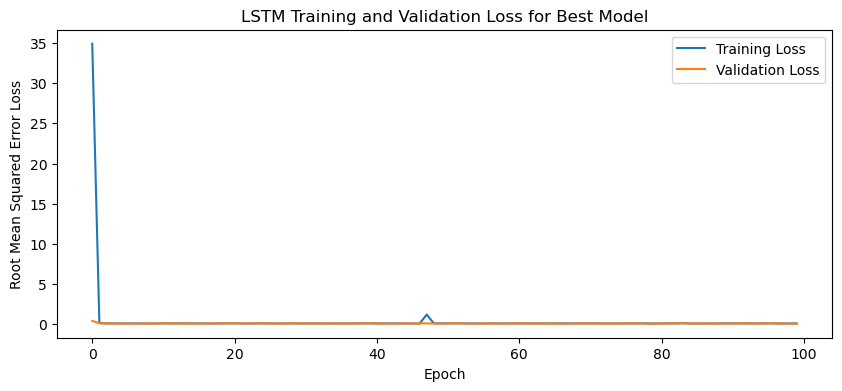

1/1 - 2s - loss: 0.1247 - 2s/epoch - 2s/step
Test Loss: 0.12465652078390121
Fold 2:
Epoch 1/100
19/19 [==============================] - 8s 108ms/step - loss: 20.3394 - val_loss: 0.3403
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.2049 - val_loss: 0.0913
Epoch 3/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1076 - val_loss: 0.0913
Epoch 4/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1051 - val_loss: 0.0807
Epoch 5/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1019 - val_loss: 0.1165
Epoch 6/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1031 - val_loss: 0.0934
Epoch 7/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1014 - val_loss: 0.0762
Epoch 8/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1069 - val_loss: 0.1106
Epoch 9/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1085 - val_loss: 0.0708
Epoch 10/100
1

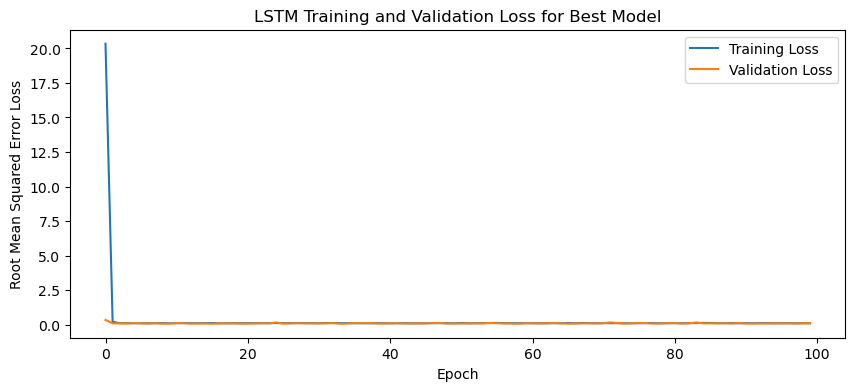

1/1 - 2s - loss: 0.0626 - 2s/epoch - 2s/step
Test Loss: 0.06259498745203018
Fold 3:
Epoch 1/100
19/19 [==============================] - 8s 119ms/step - loss: 53.1353 - val_loss: 0.3336
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 0.6535 - val_loss: 0.1474
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1347 - val_loss: 0.0983
Epoch 4/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1055 - val_loss: 0.1195
Epoch 5/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1184 - val_loss: 0.1110
Epoch 6/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1097 - val_loss: 0.1466
Epoch 7/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1122 - val_loss: 0.0991
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1165 - val_loss: 0.0658
Epoch 9/100
19/19 [==============================] - 0s 23ms/step - loss: 0.1214 - val_loss: 0.0726
Epoch 10/100
1

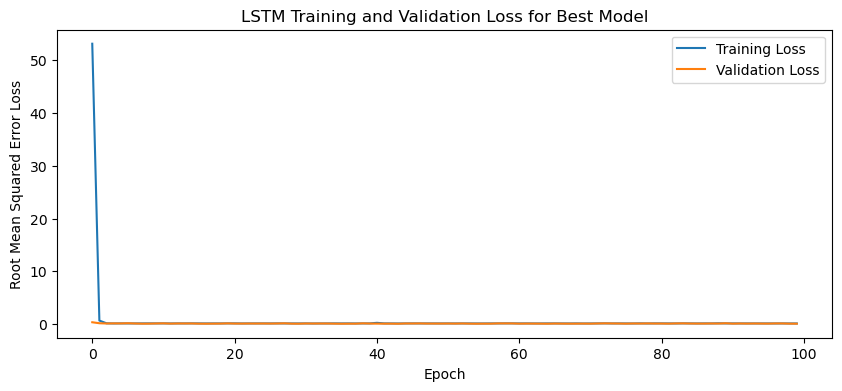

1/1 - 3s - loss: 0.0766 - 3s/epoch - 3s/step
Test Loss: 0.07662054151296616
Fold 4:
Epoch 1/100
20/20 [==============================] - 15s 90ms/step - loss: 22.9250 - val_loss: 1.4136
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 0.2444 - val_loss: 0.2433
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1314 - val_loss: 0.1687
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1010 - val_loss: 0.1147
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1019 - val_loss: 0.1130
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0991 - val_loss: 0.1756
Epoch 7/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0954 - val_loss: 0.1304
Epoch 8/100
20/20 [==============================] - 0s 19ms/step - loss: 0.1050 - val_loss: 0.1455
Epoch 9/100
20/20 [==============================] - 0s 20ms/step - loss: 0.1057 - val_loss: 0.1744
Epoch 10/100
2

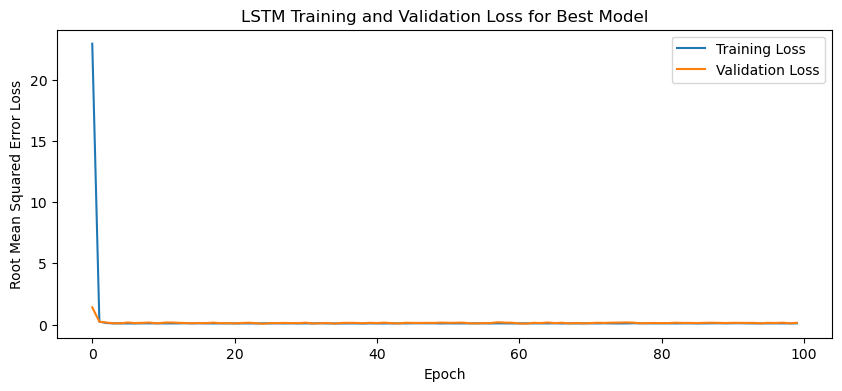

1/1 - 4s - loss: 0.1128 - 4s/epoch - 4s/step
Test Loss: 0.11283177882432938
Fold 5:
Epoch 1/100
19/19 [==============================] - 18s 218ms/step - loss: 40.7223 - val_loss: 0.4737
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 2.0267 - val_loss: 0.2229
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.1134 - val_loss: 0.1223
Epoch 4/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0902 - val_loss: 0.1106
Epoch 5/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0934 - val_loss: 0.1584
Epoch 6/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0938 - val_loss: 0.1411
Epoch 7/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0955 - val_loss: 0.1368
Epoch 8/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0994 - val_loss: 0.1928
Epoch 9/100
19/19 [==============================] - 1s 31ms/step - loss: 0.1092 - val_loss: 0.1828
Epoch 10/100


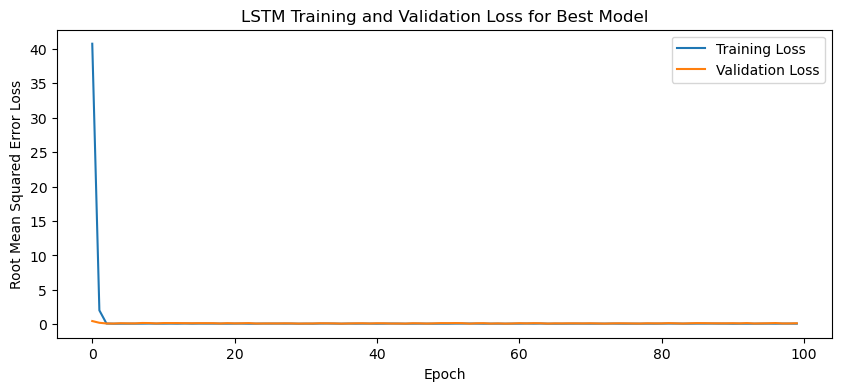

1/1 - 1s - loss: 0.0790 - 1s/epoch - 1s/step
Test Loss: 0.07901749759912491


In [4]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

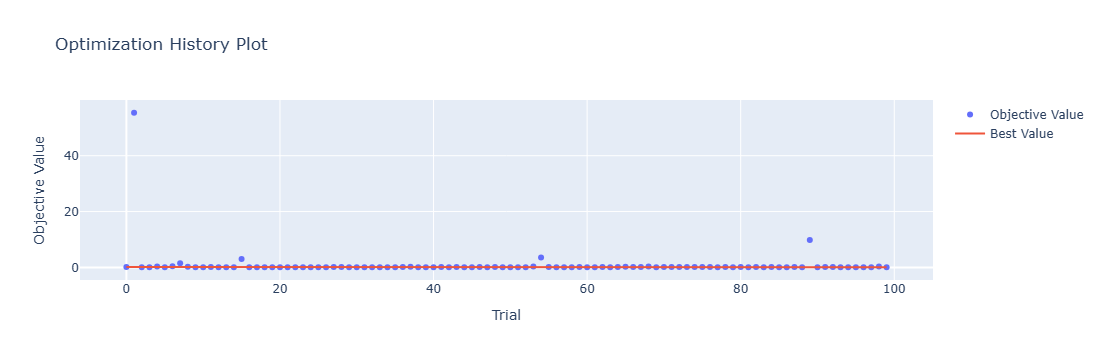

In [7]:
optuna.visualization.plot_optimization_history(study)

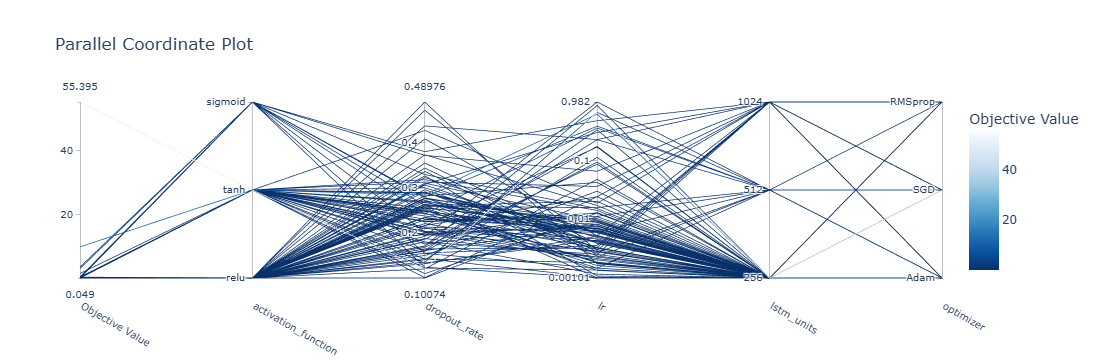

In [8]:
optuna.visualization.plot_parallel_coordinate(study)

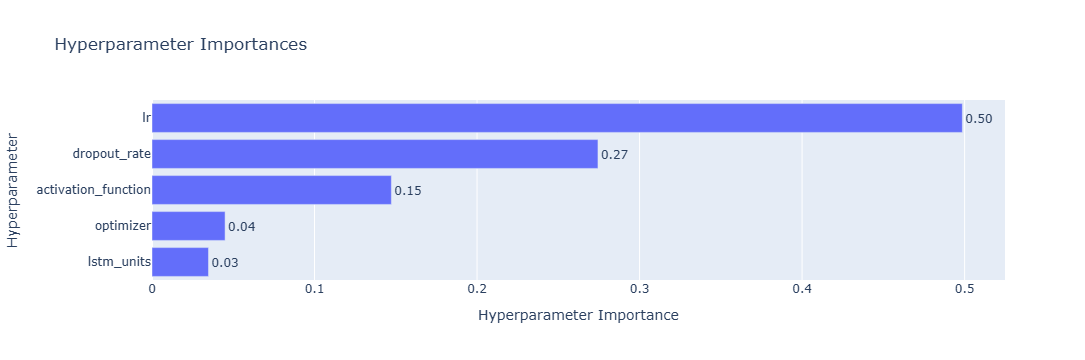

In [9]:
optuna.visualization.plot_param_importances(study)

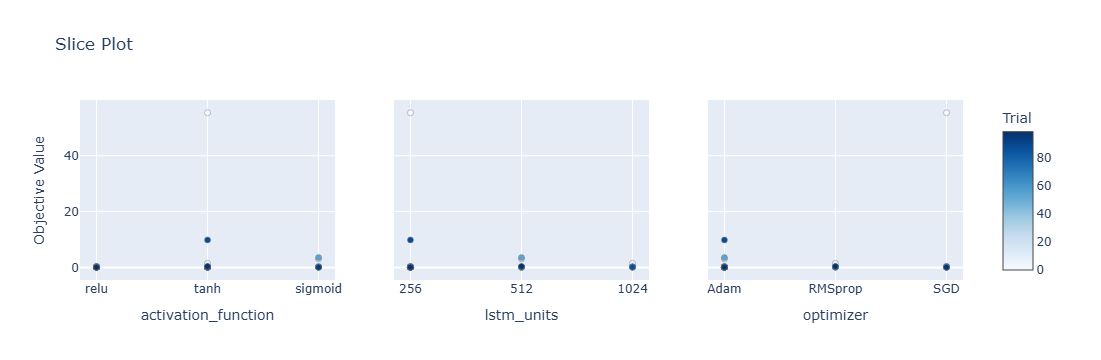

In [10]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

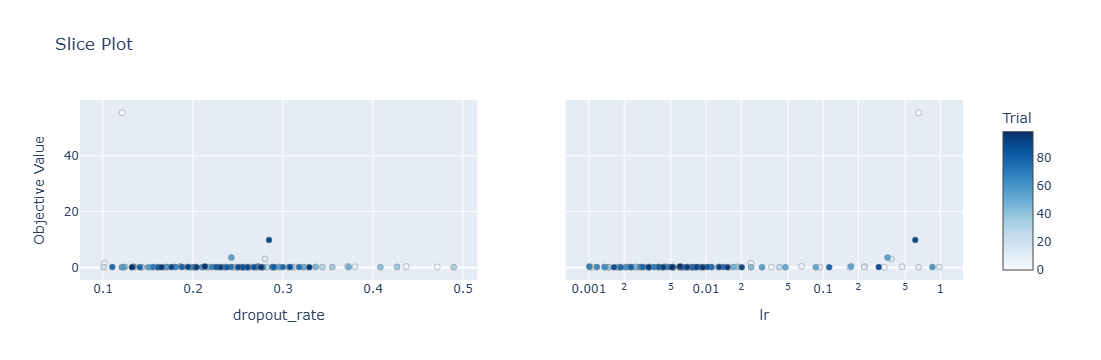

In [11]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 6s 125ms/step - loss: 30.2041 - accuracy: 0.0526 - mae: 28.3498 - rmse: 30.2041 - mape: 5280.8398 - pearson: 0.1443 - val_loss: 1.9886 - val_accuracy: 0.0000e+00 - val_mae: 1.9482 - val_rmse: 1.9886 - val_mape: 357.5503 - val_pearson: 0.1986
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 0.6574 - accuracy: 0.2632 - mae: 0.6140 - rmse: 0.6574 - mape: 109.1434 - pearson: 0.2718 - val_loss: 0.1207 - val_accuracy: 0.0000e+00 - val_mae: 0.1002 - val_rmse: 0.1207 - val_mape: 19.7035 - val_pearson: 0.4765
Epoch 3/100
19/19 [==============================] - 1s 40ms/step - loss: 0.1

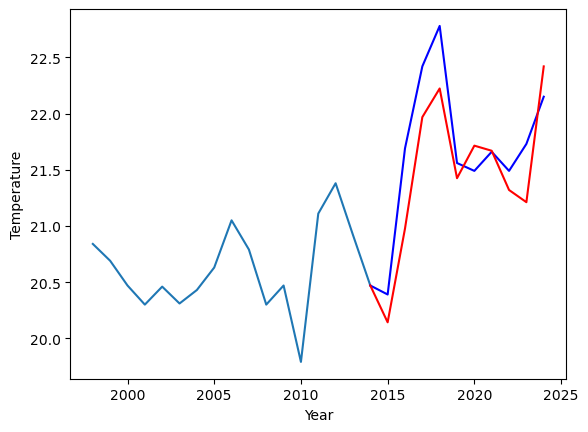

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		15.87		-0.50
17.64		16.71		-0.93
17.80		17.70		-0.10
18.04		17.95		-0.09
18.00		17.15		-0.85
18.95		17.44		-1.51
18.12		17.40		-0.72
17.61		17.05		-0.56
17.89		16.94		-0.95
17.72		18.15		0.43


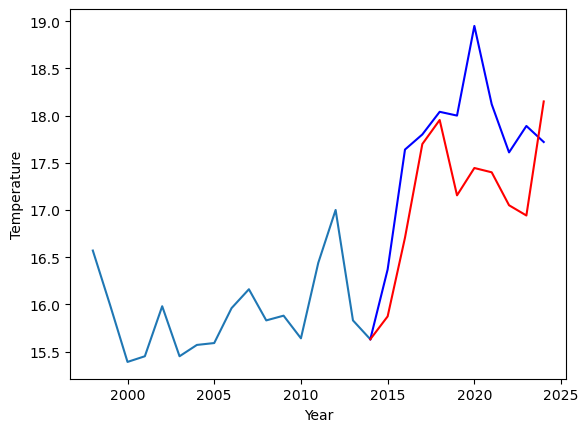

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.142447
1                1   16.37  15.872447


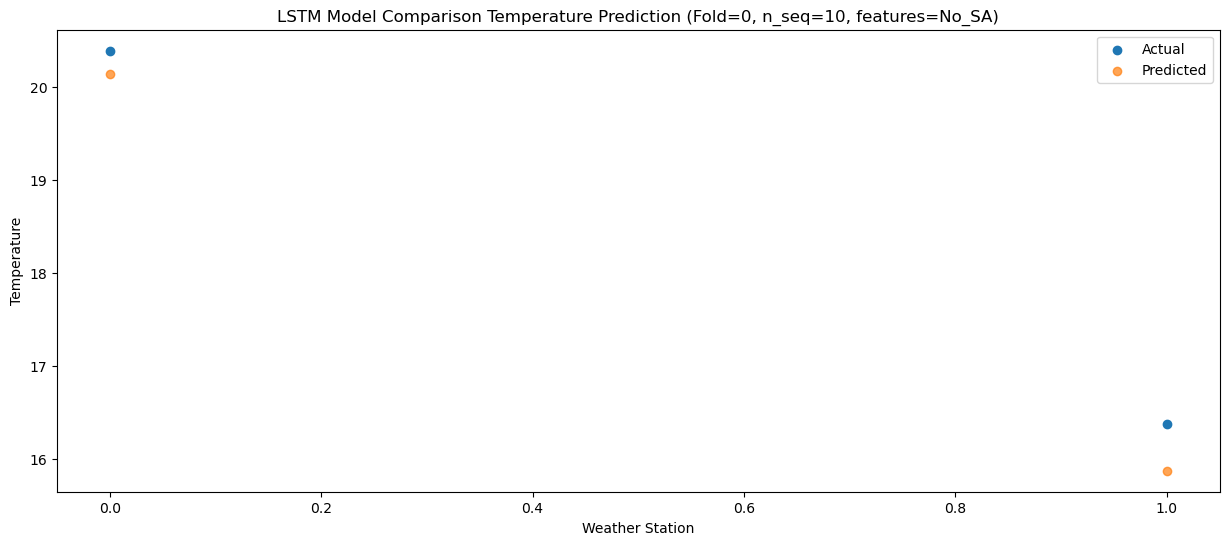

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  20.976555
1                1   17.64  16.706555


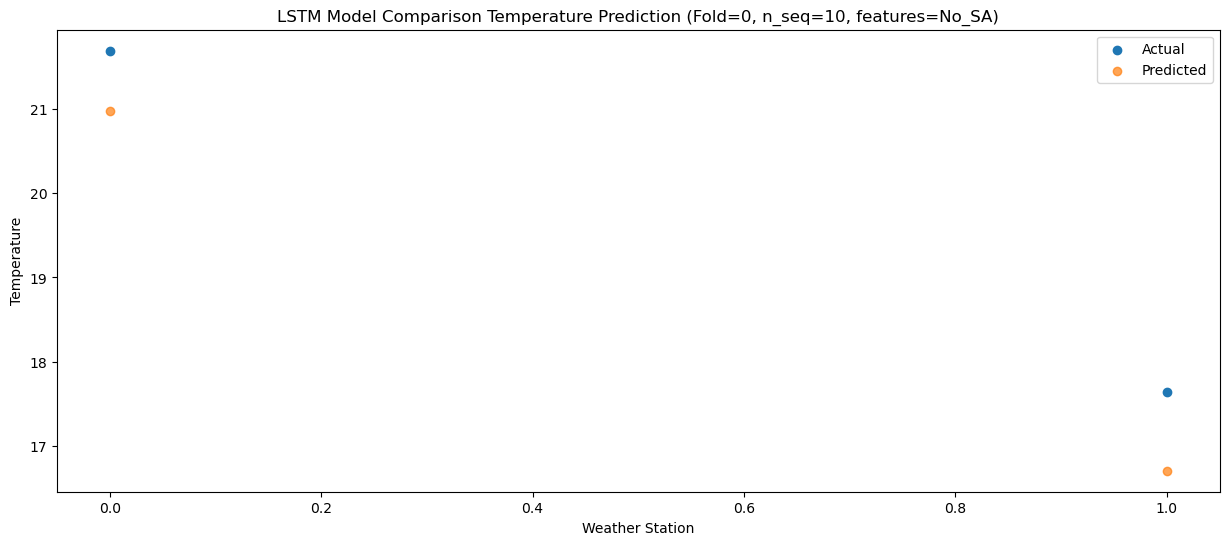

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  21.968446
1                1   17.80  17.698446


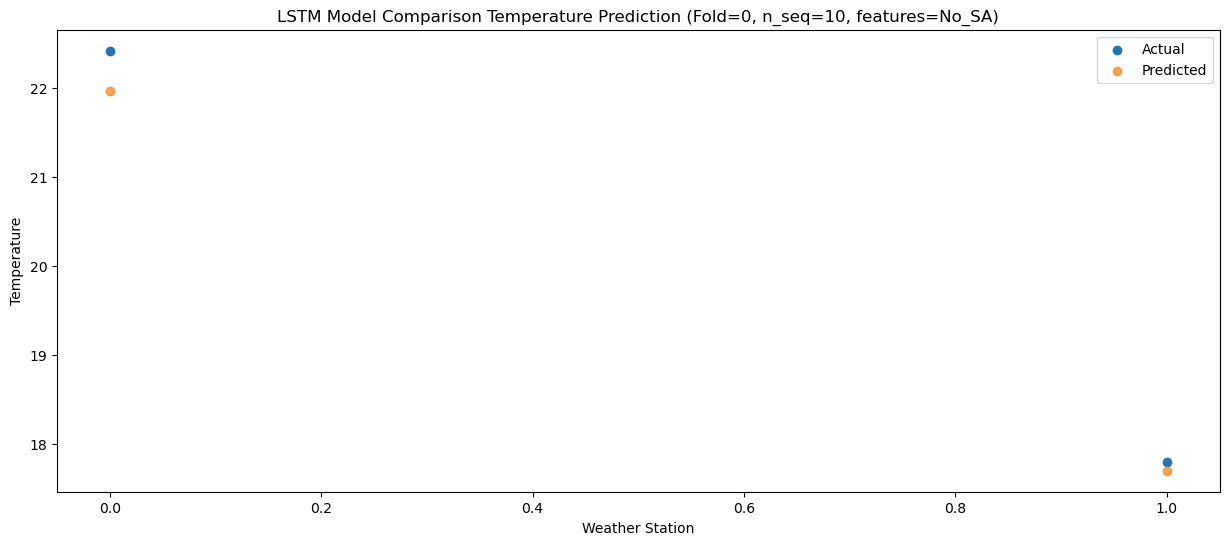

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78    22.2234
1                1   18.04    17.9534


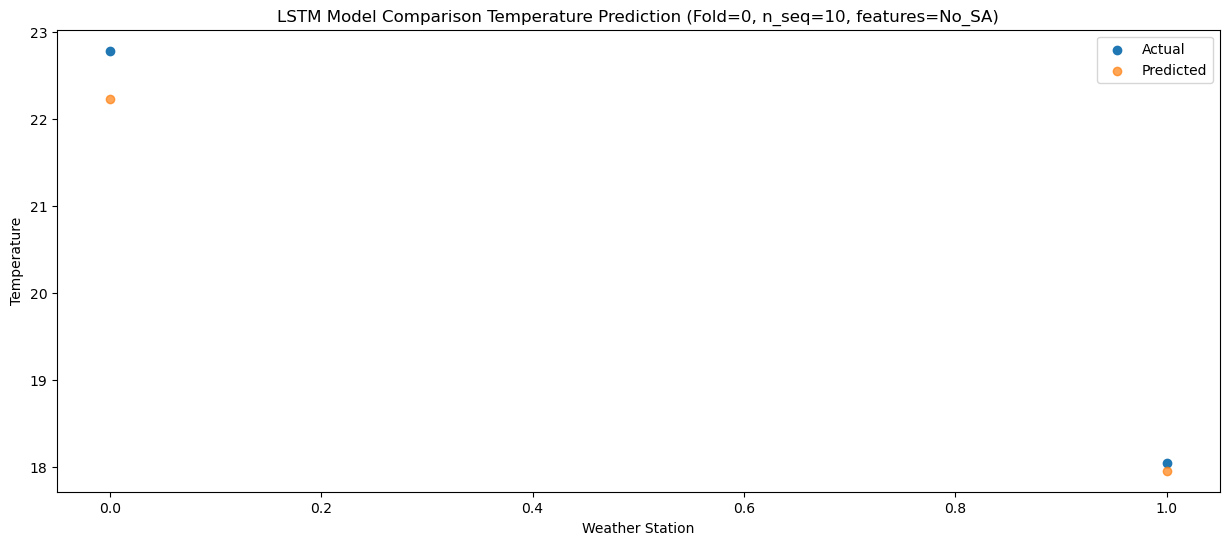

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.424974
1                1   18.00  17.154974


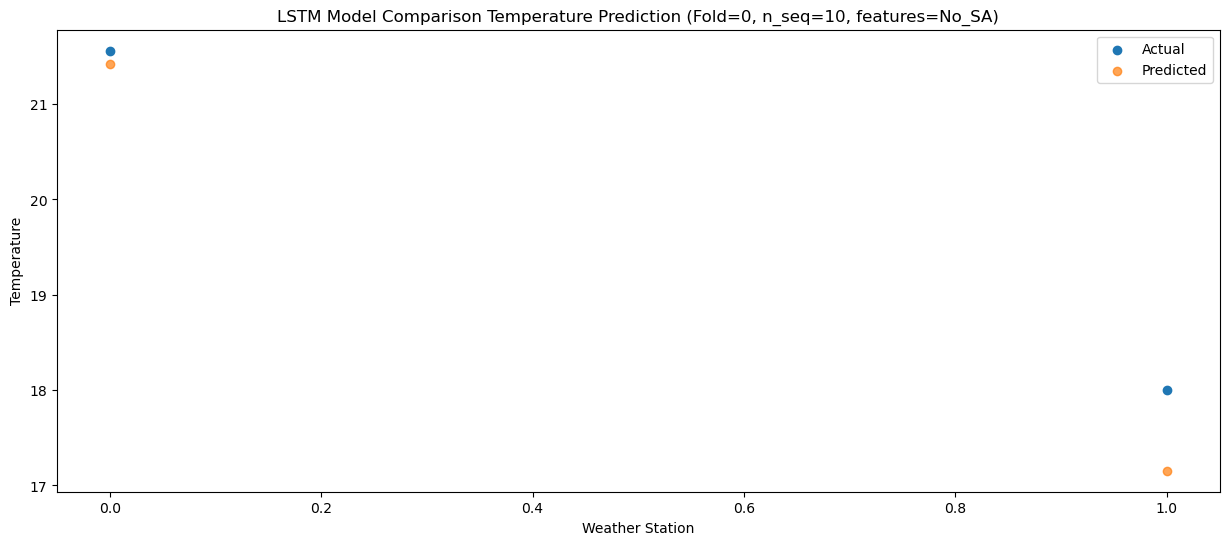

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.714563
1                1   18.95  17.444563


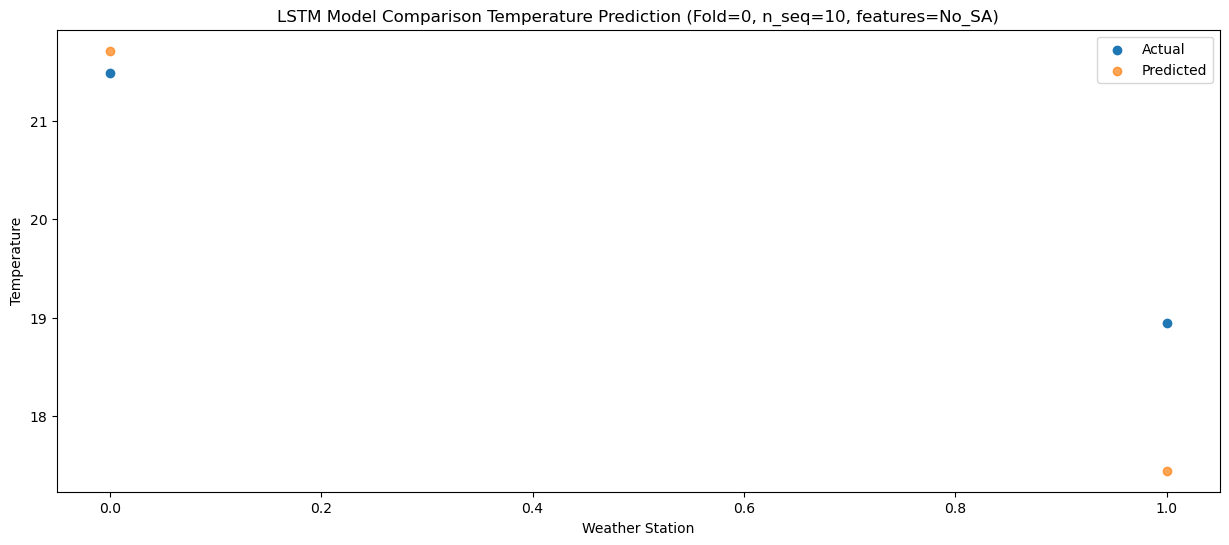

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  21.669066
1                1   18.12  17.399066


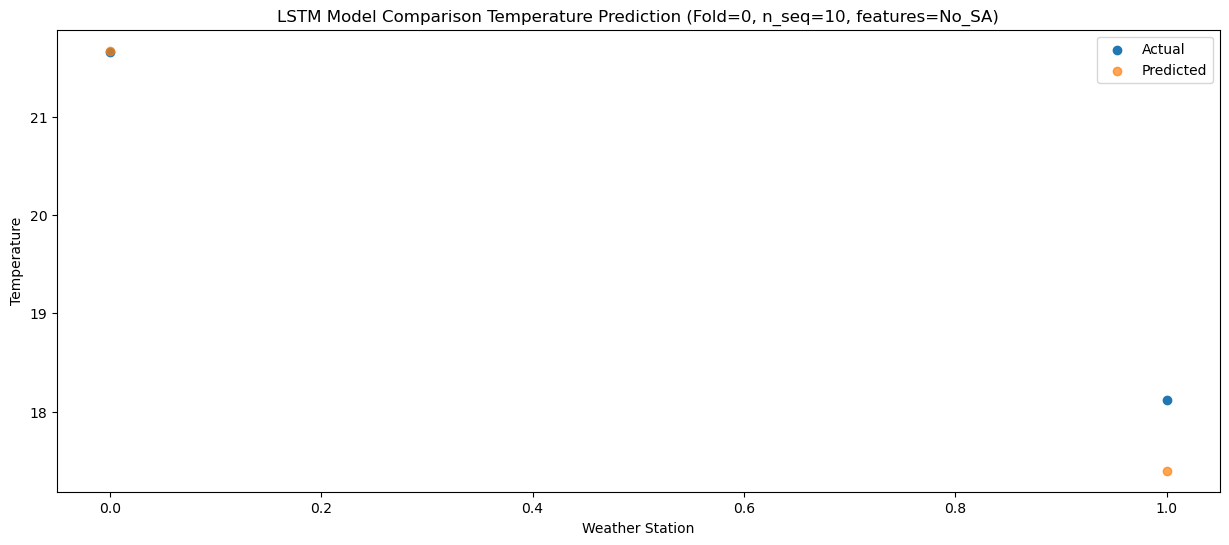

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  21.319959
1                1   17.61  17.049959


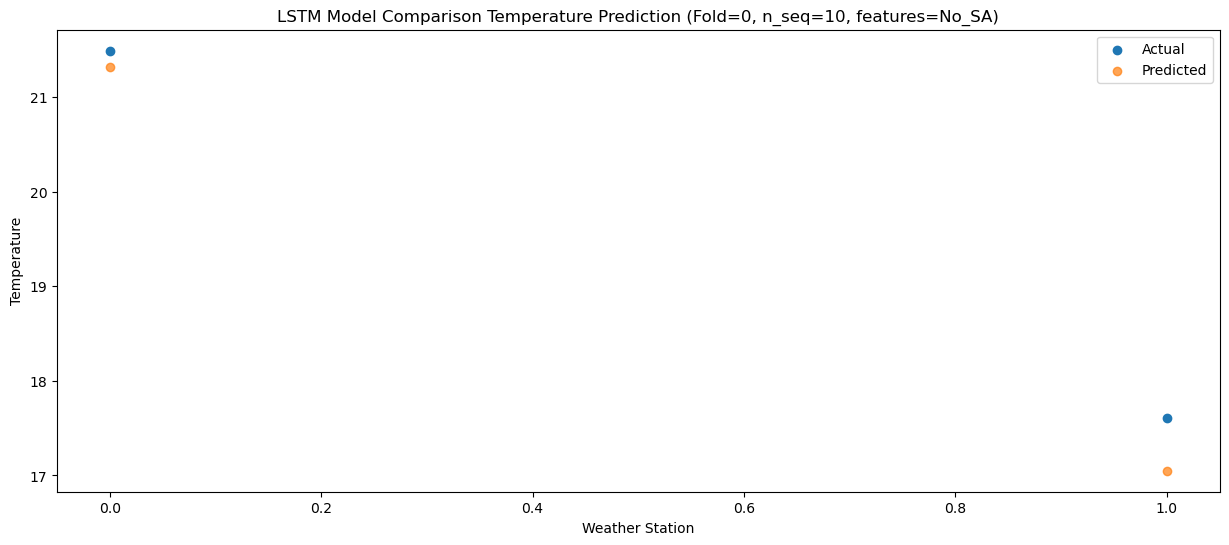

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.211396
1                1   17.89  16.941396


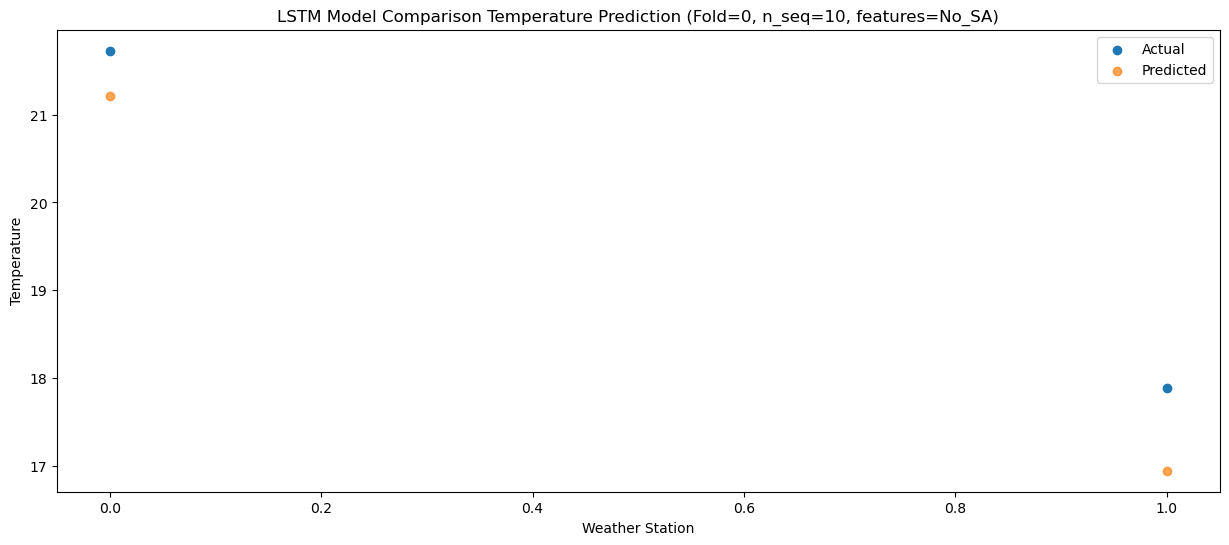

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  22.419899
1                1   17.72  18.149899


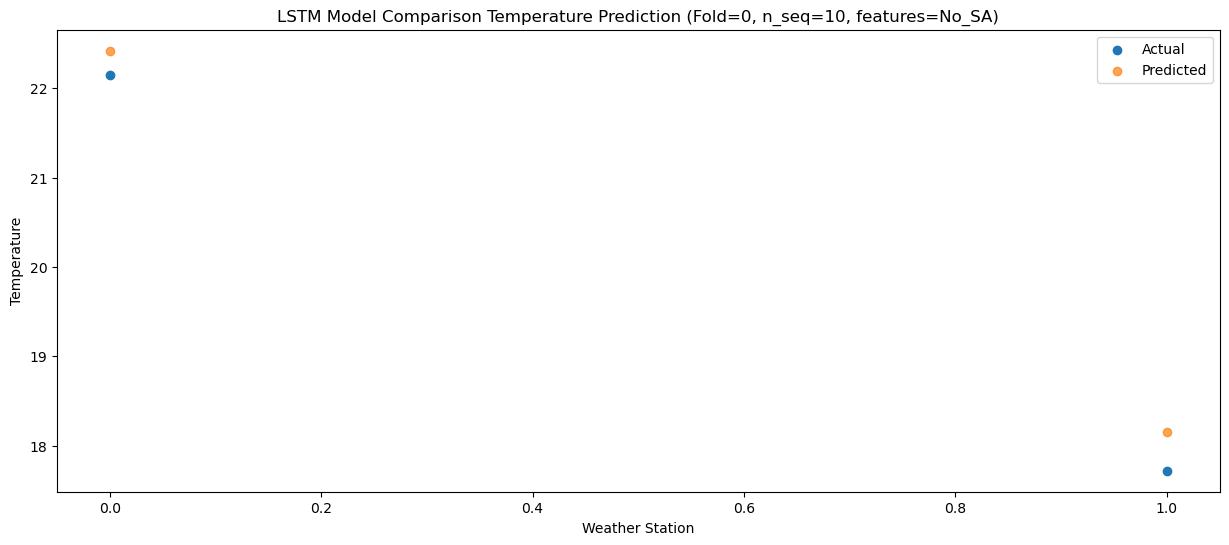

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.14244744 15.87244744]
 [20.97655519 16.70655519]
 [21.9684458  17.6984458 ]
 [22.22339967 17.95339967]
 [21.42497381 17.15497381]
 [21.71456286 17.44456286]
 [21.66906642 17.39906642]
 [21.31995939 17.04995939]
 [21.2113957  16.9413957 ]
 [22.41989943 18.14989943]]
Year at t+1:
t+1 SKRMSE: 0.392964
t+1 KRMSE: 0.392964
t+1 MAE: 0.372553
t+1 SKMAPE: 0.021268
t+1 R2_SCORE: 0.961778
t+1 KMAPE: 0.021268
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.830760
t+2 KRMSE: 0.830760
t+2 MAE: 0.823445
t+2 SKMAPE: 0.042905
t+2 R2_SCORE: 0.831694
t+2 KMAPE: 0.042905
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.327272
t+3 KRMSE: 0.327272
t+3 MAE: 0.276554
t+3 SKMAPE: 0.012923
t+3 R2_SCORE: 0.979928
t+3 KMAPE: 0.012923
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.398311
t+4 KRMSE: 0.398311
t+4 MAE: 0.321600
t+4 SKMAPE: 0.014617
t+4 R

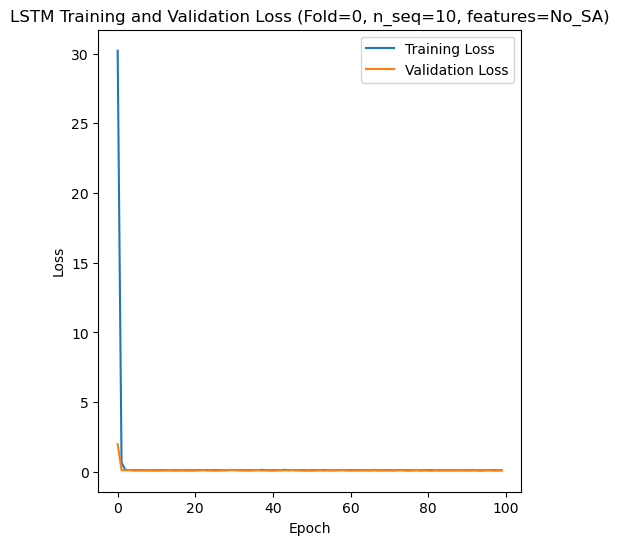

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 6s 84ms/step - loss: 44.3153 - accuracy: 0.2632 - mae: 43.3939 - rmse: 44.3153 - mape: 7079.2993 - pearson: 0.1249 - val_loss: 0.4504 - val_accuracy: 0.0000e+00 - val_mae: 0.3808 - val_rmse: 0.4504 - val_mape: 60.2207 - val_pearson: 0.3855
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 0.9248 - accuracy: 0.2105 - mae: 0.8677 - rmse: 0.9248 - mape: 142.4797 - pearson: 0.1583 - val_loss: 0.1223 - val_accuracy: 0.0000e+00 - val_mae: 0.1067 - val_rmse: 0.1223 - val_mape: 16.7013 - val_pearson: 0.5269
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.2078

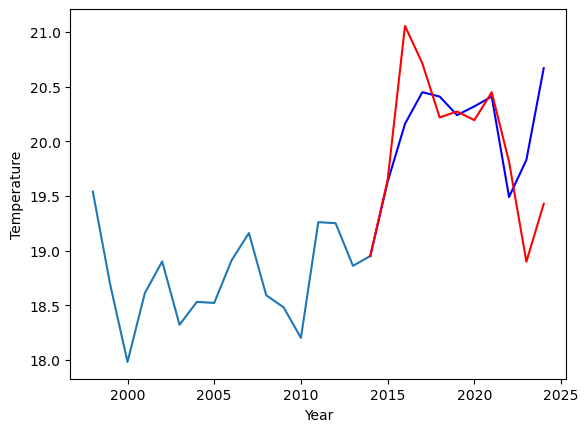

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.80		-0.08
19.40		21.21		1.81
20.43		20.86		0.43
20.81		20.37		-0.44
19.96		20.42		0.46
20.09		20.34		0.25
20.61		20.60		-0.01
20.22		19.96		-0.26
20.22		19.05		-1.17
21.53		19.58		-1.95


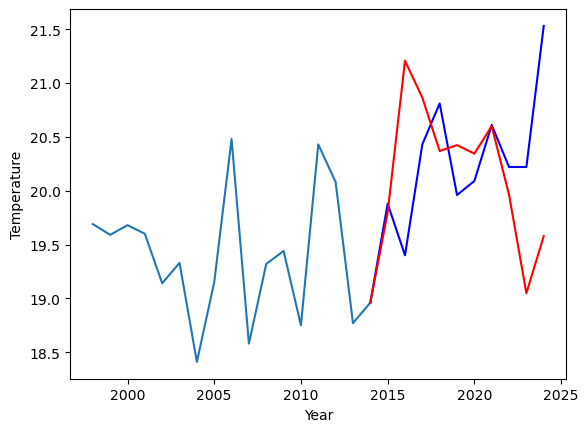

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  19.646375
1                1   19.88  19.796375


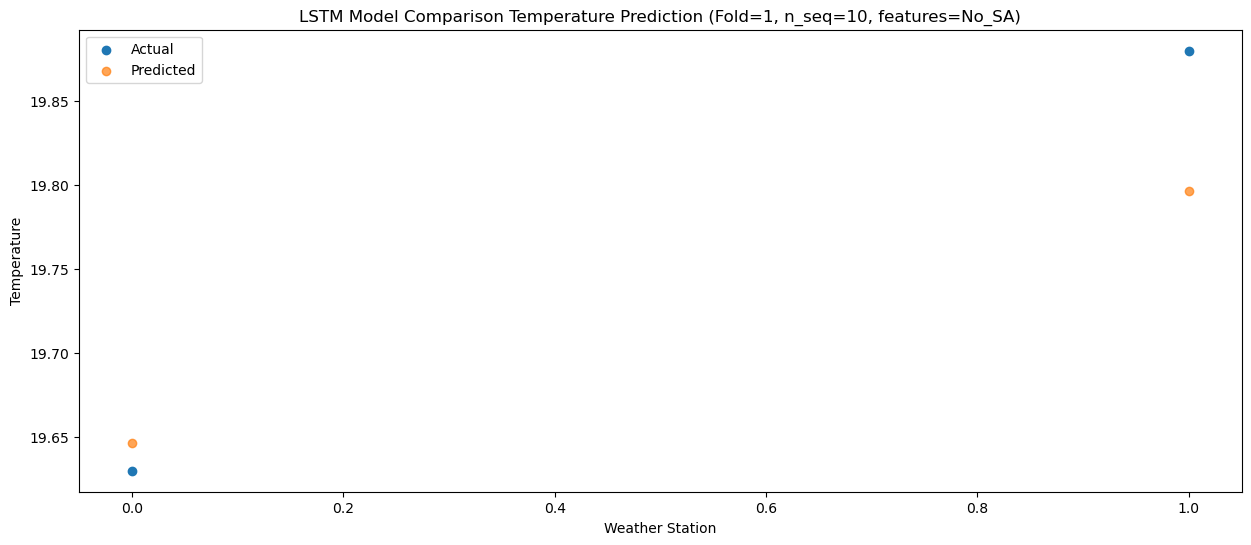

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  21.056736
1                1   19.40  21.206736


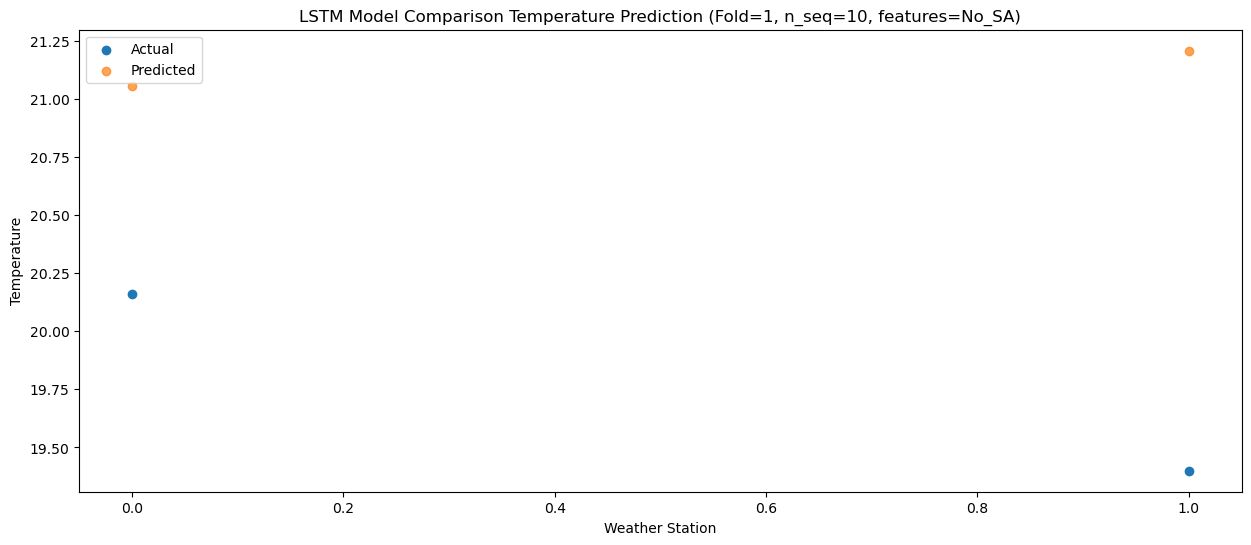

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  20.714053
1                1   20.43  20.864053


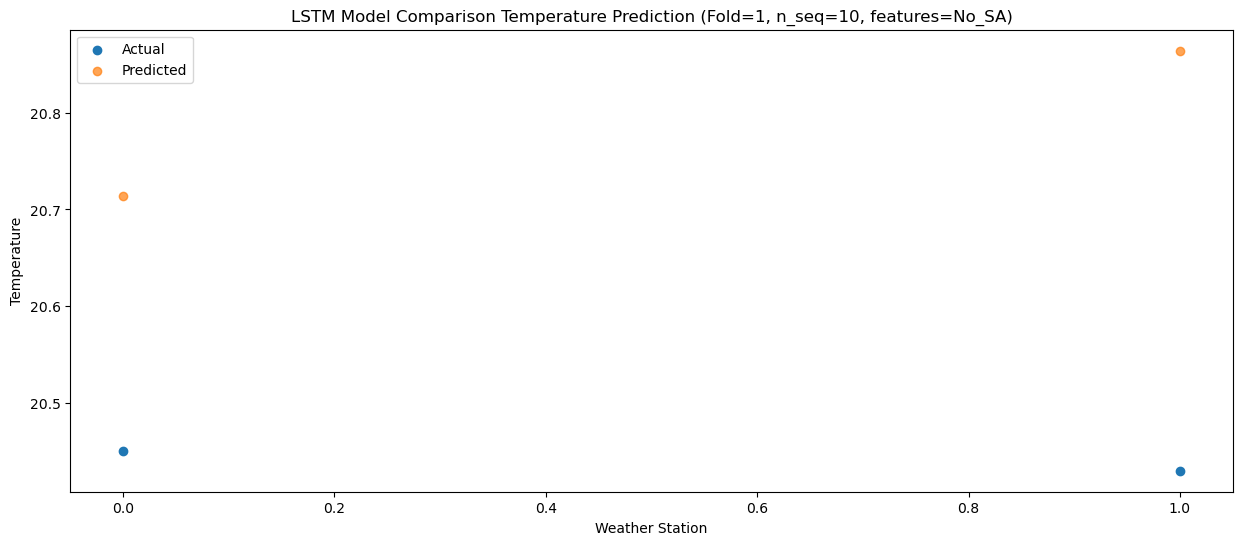

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41   20.21881
1                1   20.81   20.36881


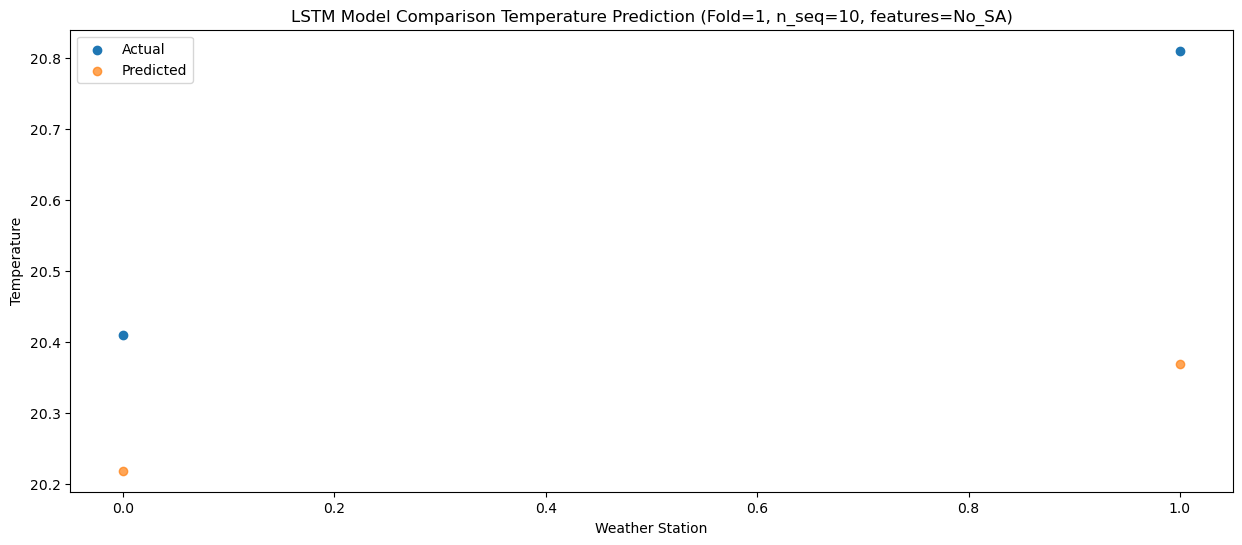

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  20.273236
1                1   19.96  20.423236


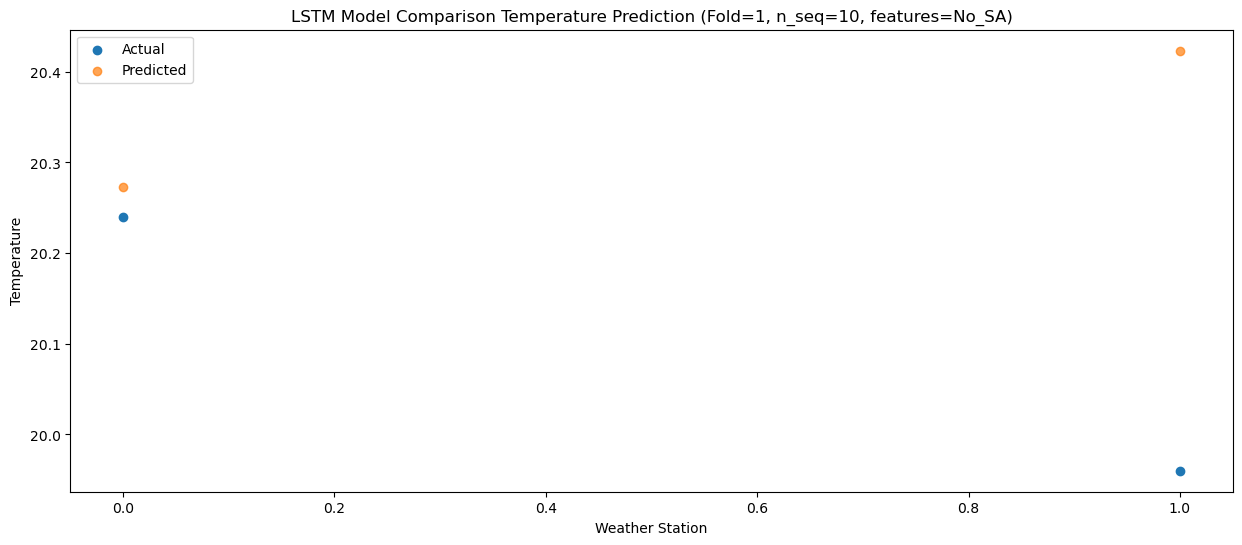

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  20.193991
1                1   20.09  20.343991


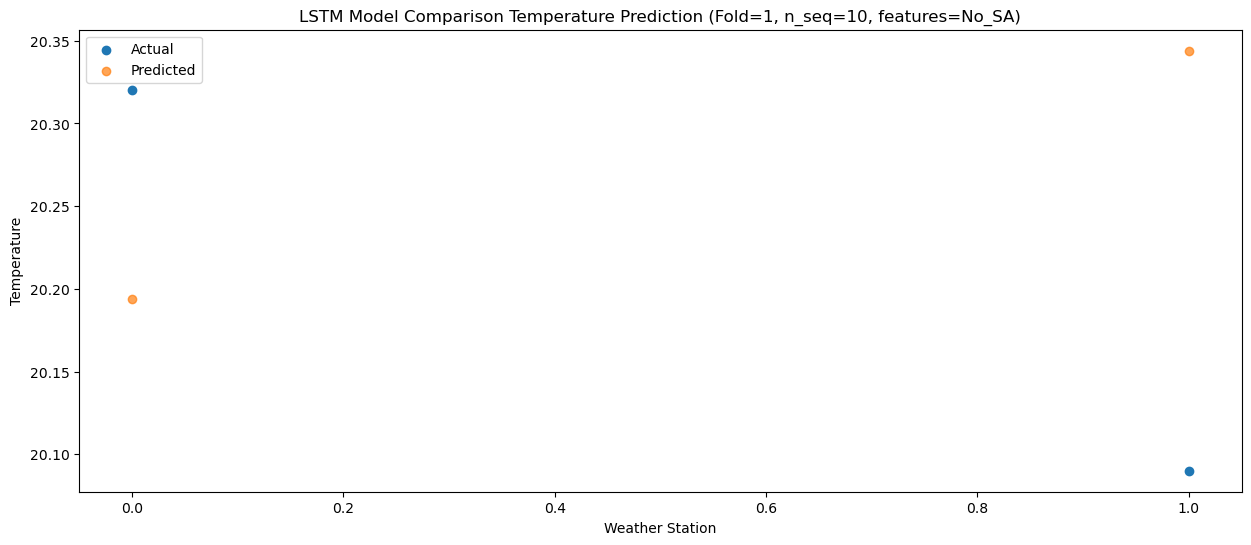

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  20.449097
1                1   20.61  20.599097


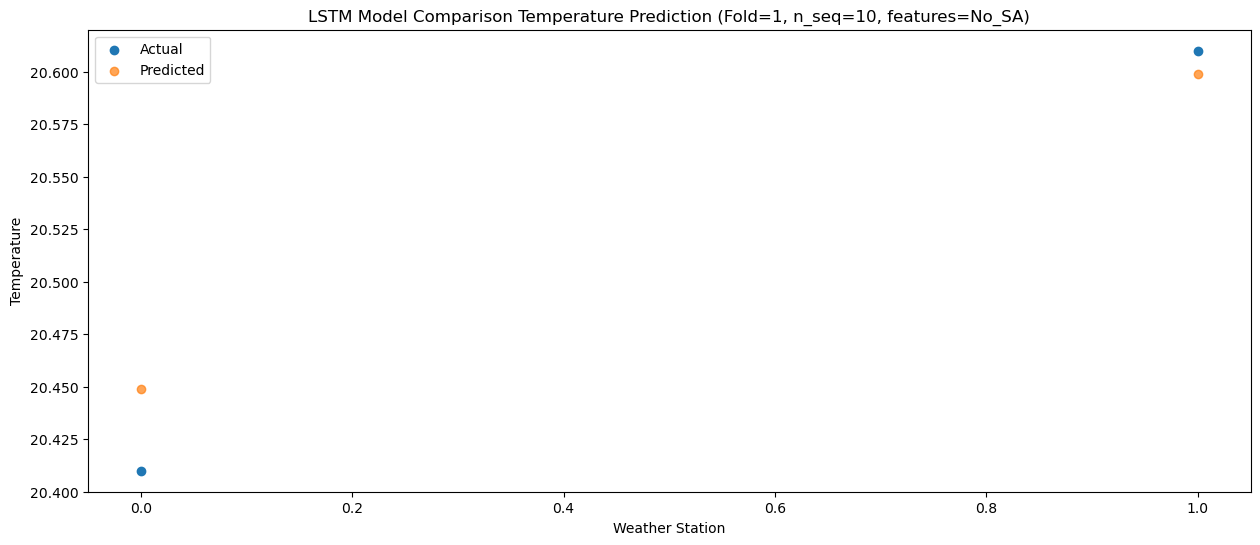

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  19.812601
1                1   20.22  19.962601


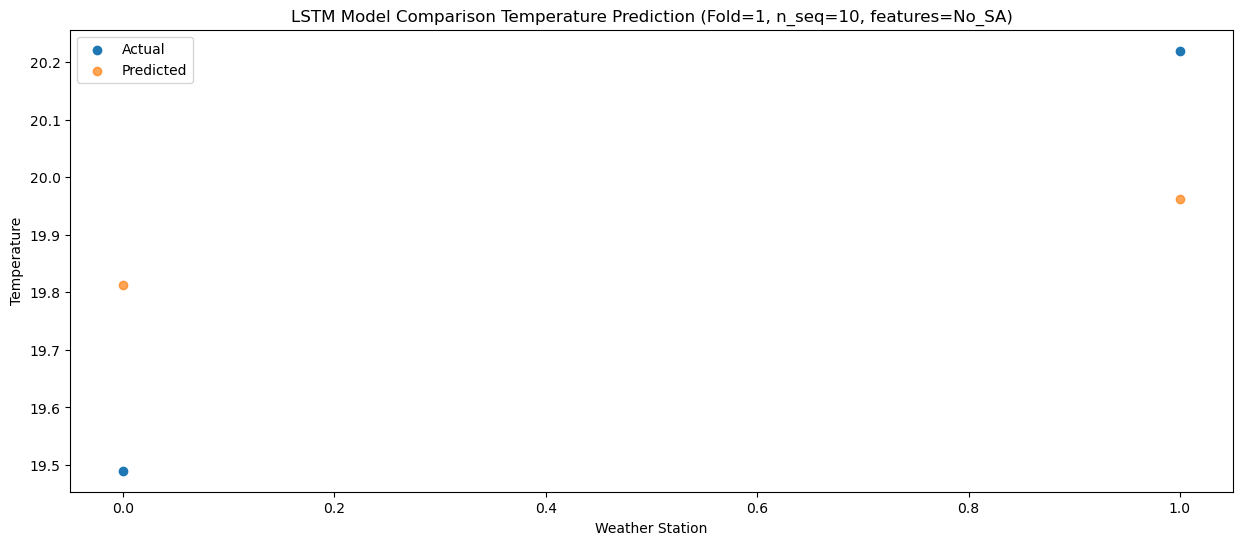

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  18.897516
1                1   20.22  19.047516


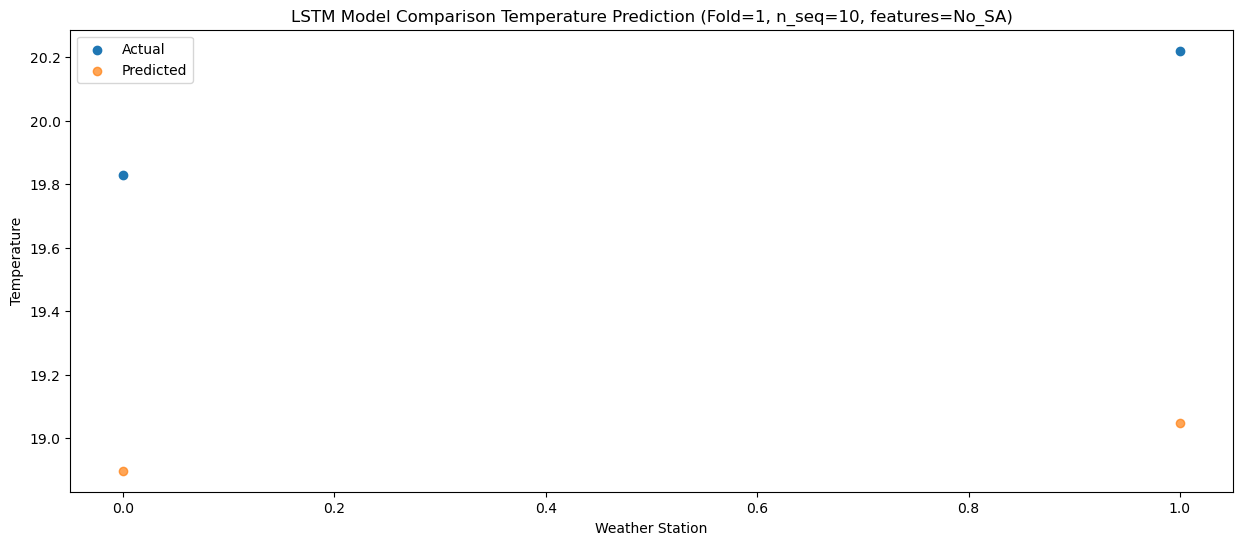

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67   19.42749
1                1   21.53   19.57749


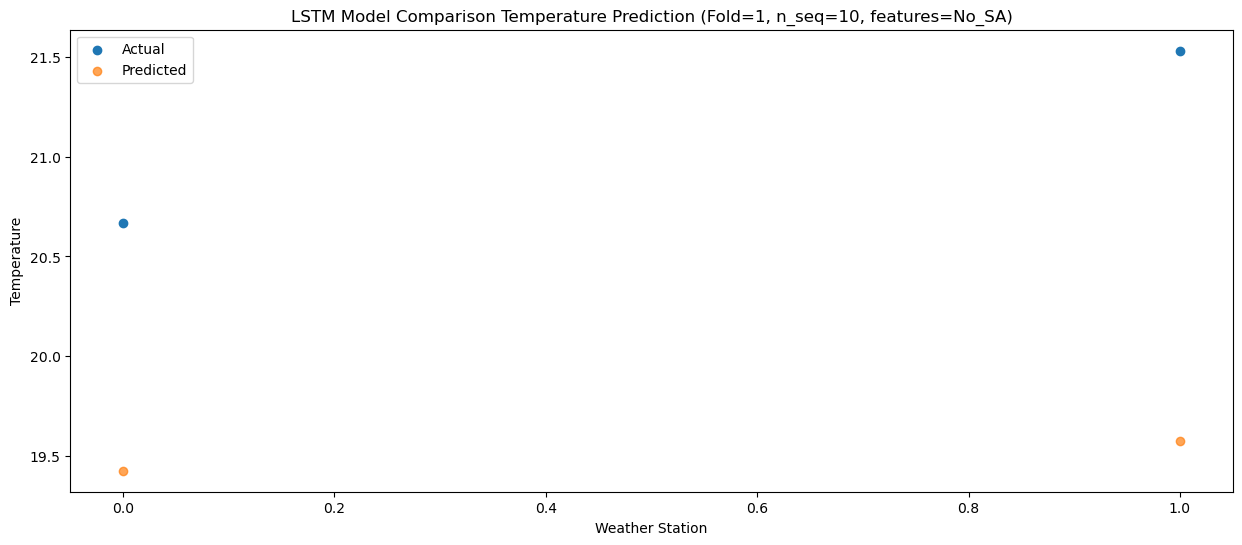

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[19.6463747  19.7963747 ]
 [21.05673564 21.20673564]
 [20.71405333 20.86405333]
 [20.21881017 20.36881017]
 [20.27323591 20.42323591]
 [20.19399106 20.34399106]
 [20.44909721 20.59909721]
 [19.81260097 19.96260097]
 [18.89751619 19.04751619]
 [19.42749017 19.57749017]]
Year at t+1:
t+1 SKRMSE: 0.060255
t+1 KRMSE: 0.060255
t+1 MAE: 0.050000
t+1 SKMAPE: 0.002520
t+1 R2_SCORE: 0.767638
t+1 KMAPE: 0.002520
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.426259
t+2 KRMSE: 1.426259
t+2 MAE: 1.351736
t+2 SKMAPE: 0.068806
t+2 R2_SCORE: -13.087356
t+2 KMAPE: 0.068806
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.359254
t+3 KRMSE: 0.359254
t+3 MAE: 0.349053
t+3 SKMAPE: 0.017079
t+3 R2_SCORE: -1289.632298
t+3 KMAPE: 0.017079
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.340001
t+4 KRMSE: 0.340001
t+4 MAE: 0.316190
t+4 SKMAPE: 0.015284

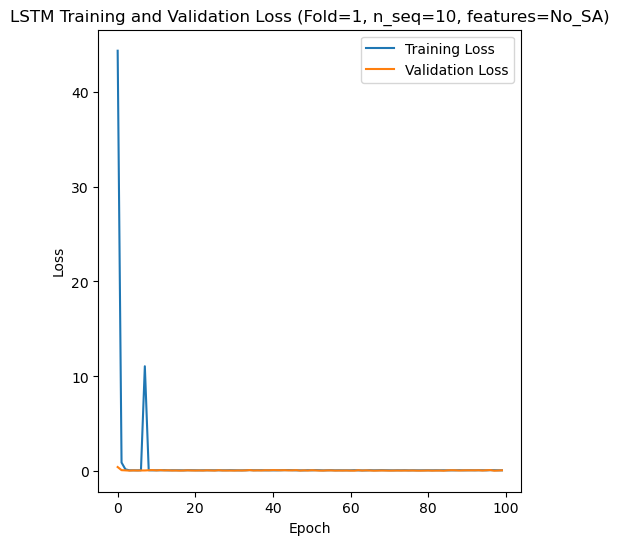

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 5s 79ms/step - loss: 32.8145 - accuracy: 0.0526 - mae: 31.8527 - rmse: 32.8145 - mape: 5425.0840 - pearson: 0.1084 - val_loss: 0.1038 - val_accuracy: 0.0000e+00 - val_mae: 0.0893 - val_rmse: 0.1038 - val_mape: 13.8711 - val_pearson: 0.2468
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1629 - accuracy: 0.2632 - mae: 0.1312 - rmse: 0.1629 - mape: 21.6749 - pearson: 0.2650 - val_loss: 0.3140 - val_accuracy: 0.0000e+00 - val_mae: 0.2754 - val_rmse: 0.3140 - val_mape: 42.6281 - val_pearson: 0.0127
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1441 

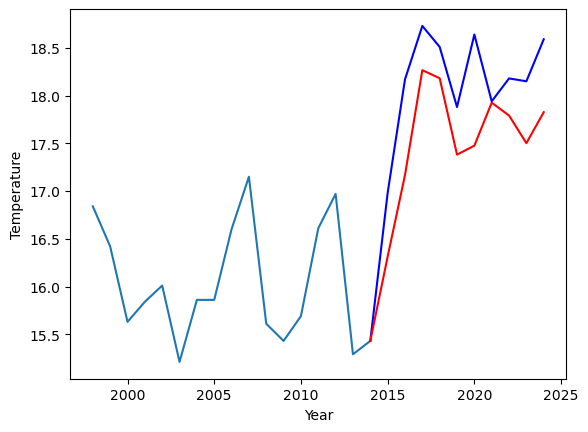

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		12.98		0.09
14.23		13.84		-0.39
15.00		14.94		-0.06
14.82		14.85		0.03
14.35		14.05		-0.30
14.68		14.15		-0.53
14.67		14.60		-0.07
14.66		14.46		-0.20
14.20		14.17		-0.03
14.99		14.50		-0.49


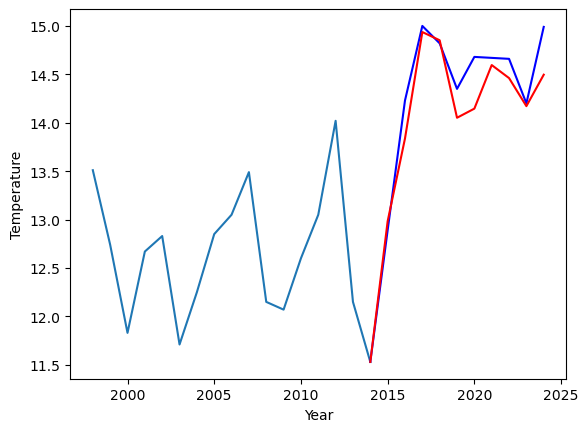

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.312743
1                1   12.89  12.982743


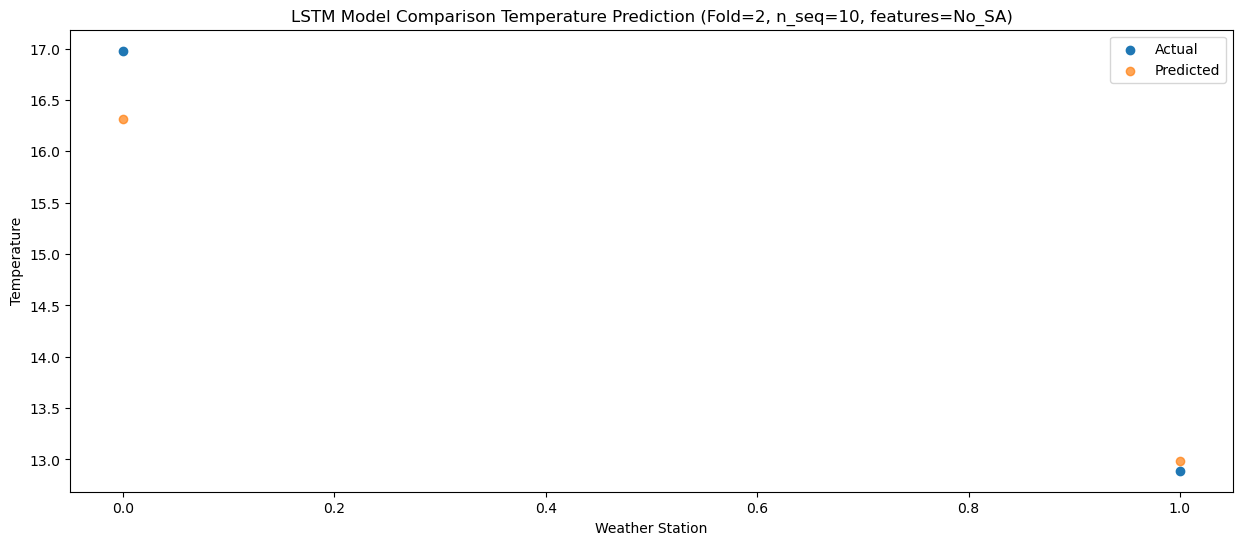

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.167615
1                1   14.23  13.837615


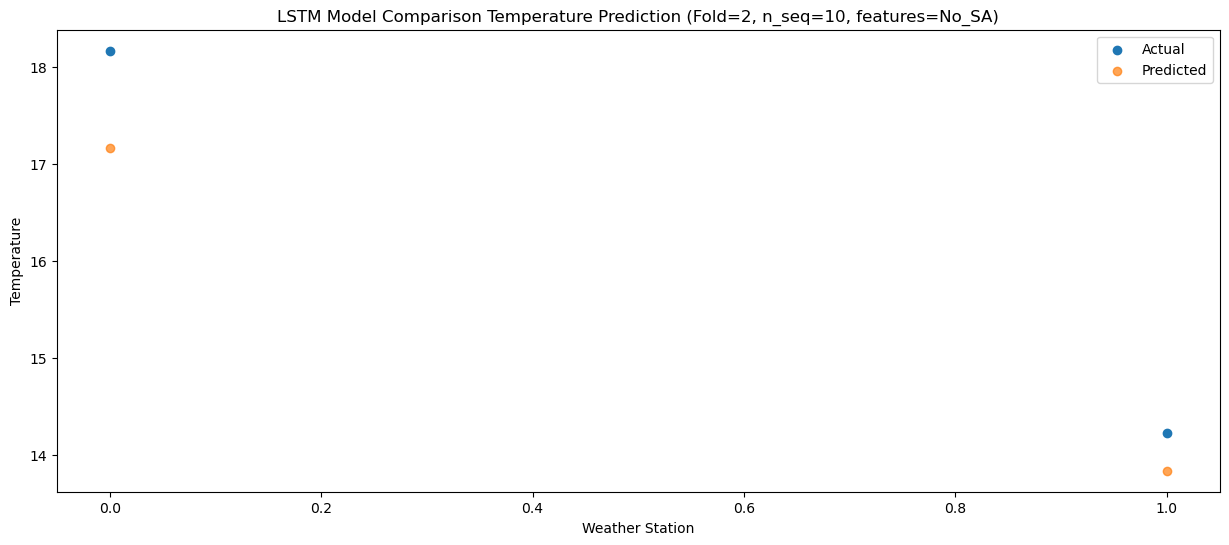

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.266731
1                1   15.00  14.936731


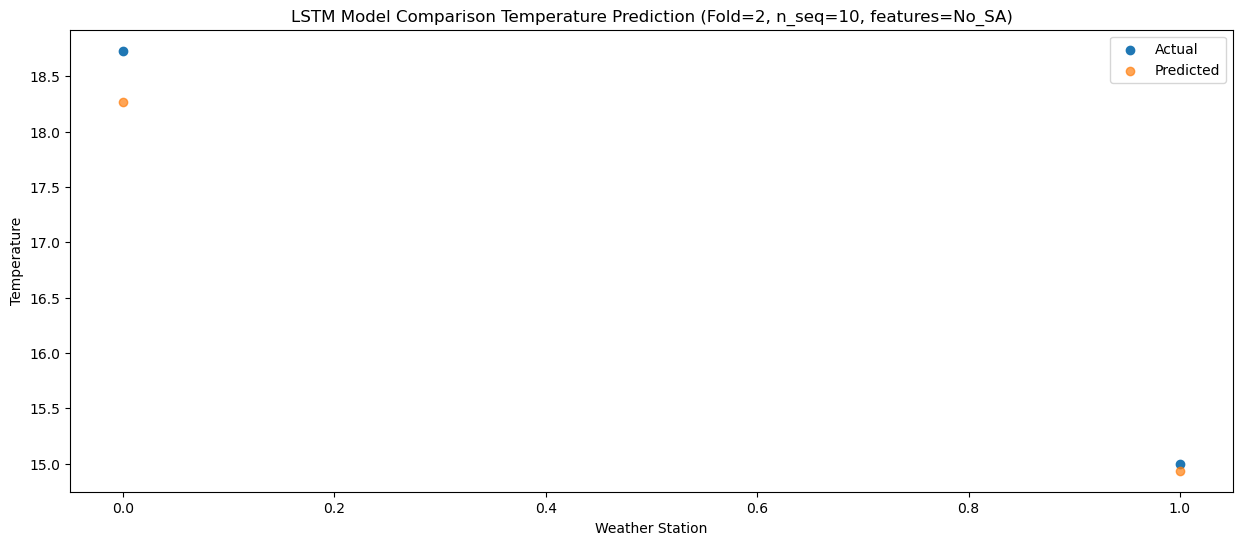

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.181867
1                1   14.82  14.851867


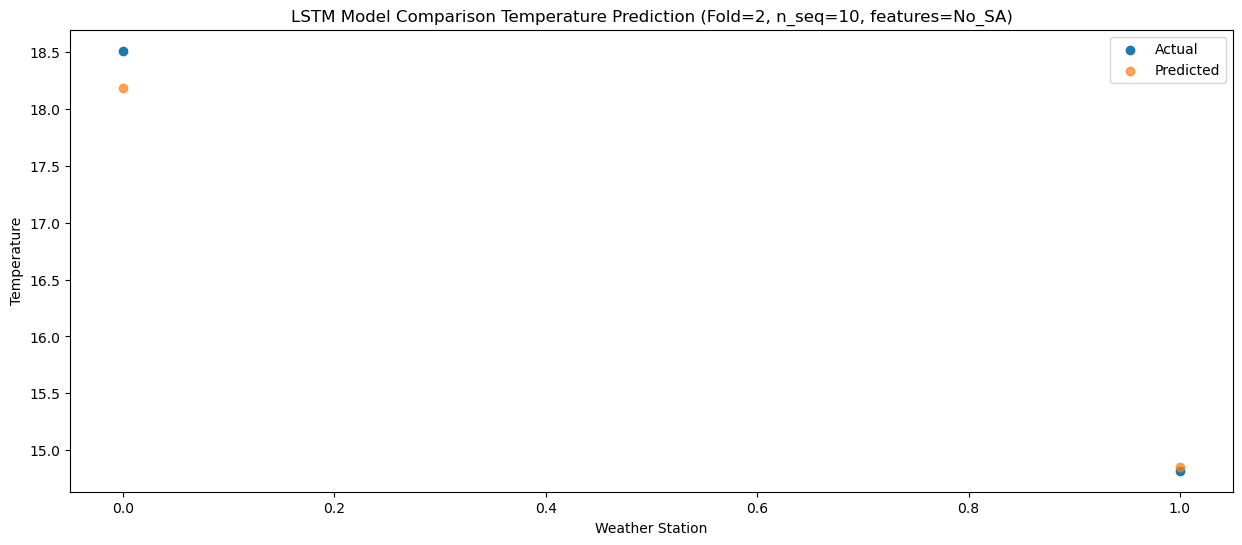

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  17.381592
1                1   14.35  14.051592


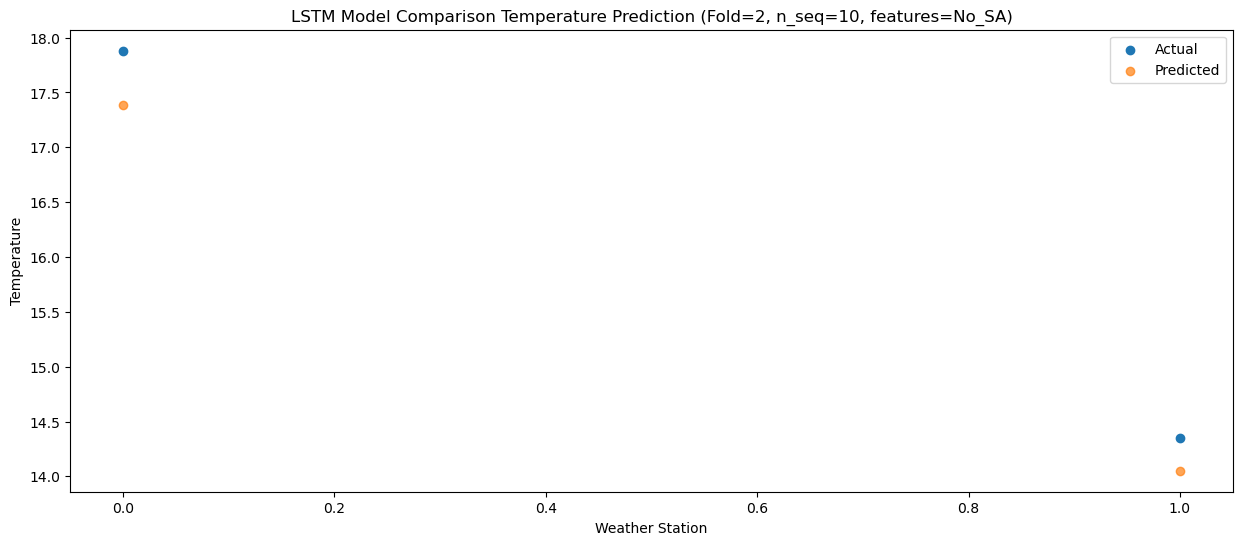

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  17.475799
1                1   14.68  14.145799


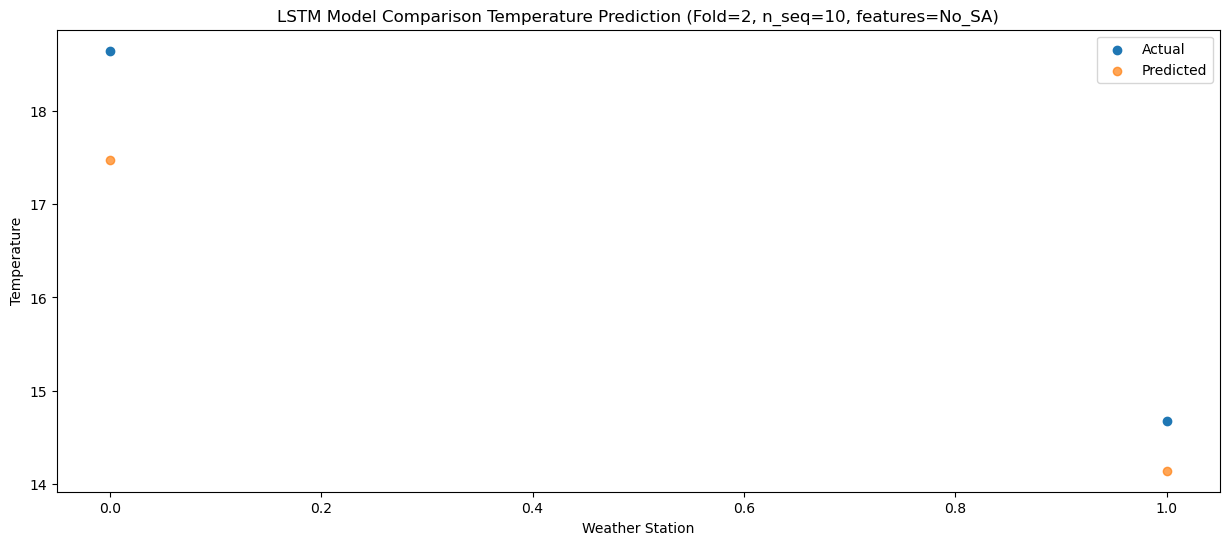

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94   17.92595
1                1   14.67   14.59595


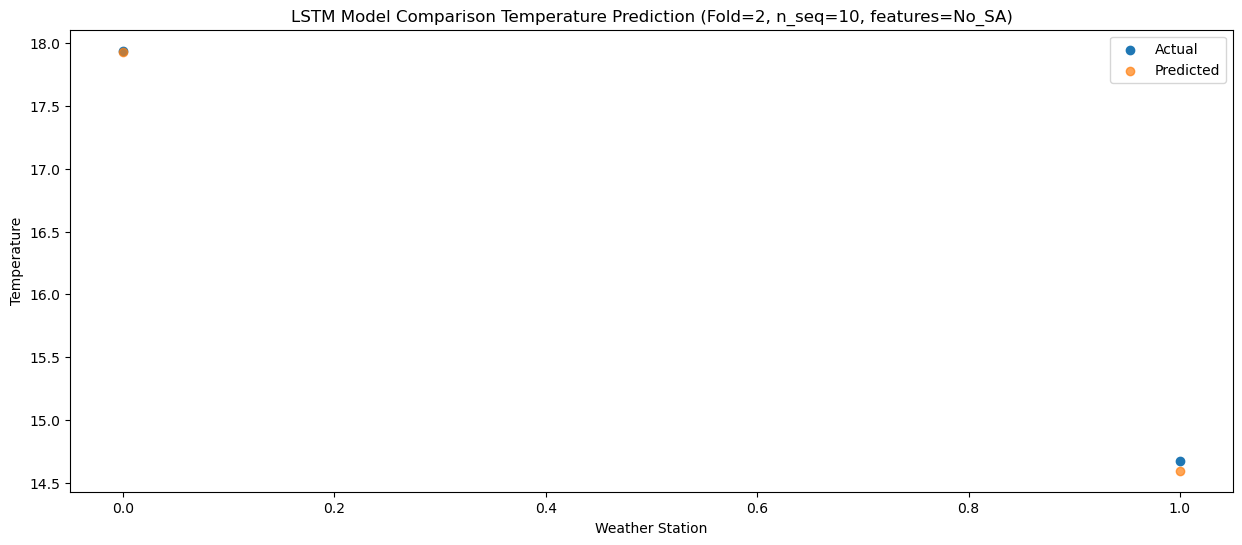

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  17.791302
1                1   14.66  14.461302


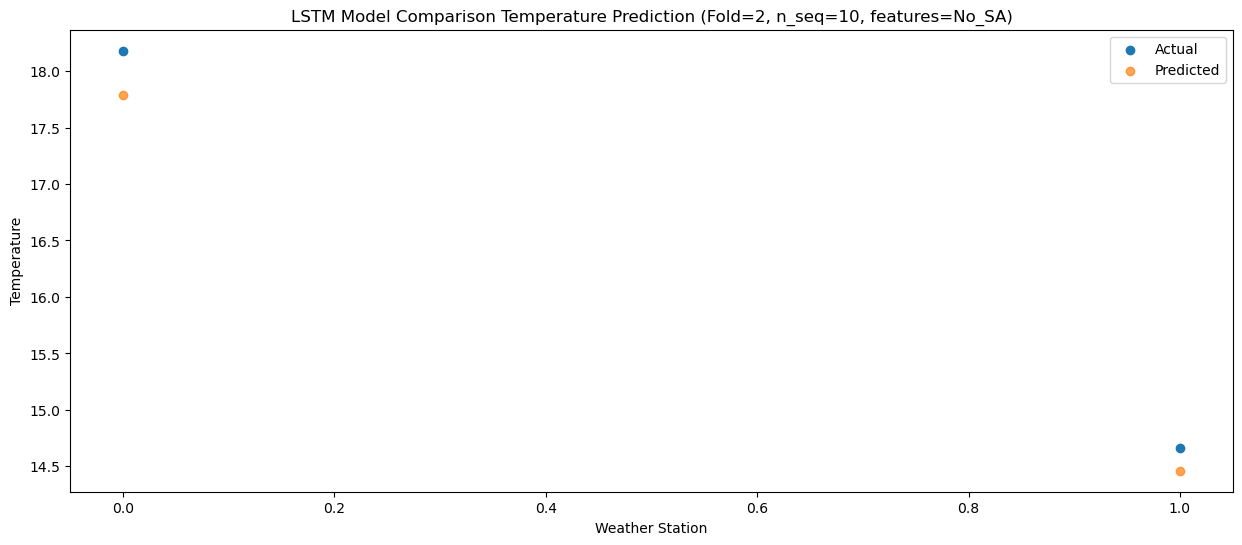

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  17.501538
1                1   14.20  14.171538


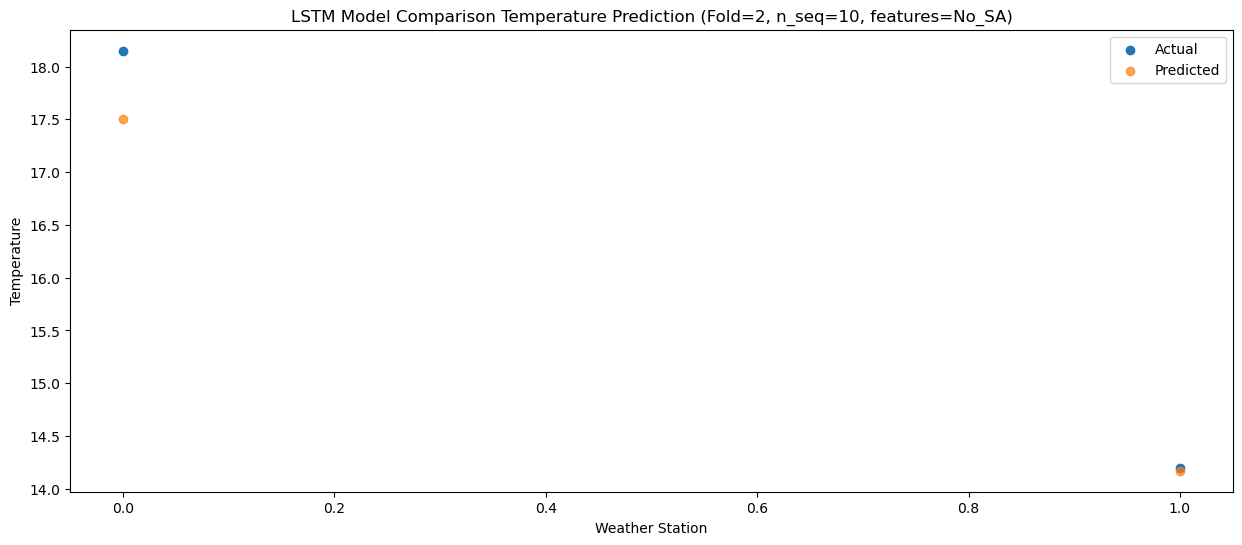

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  17.826265
1                1   14.99  14.496265


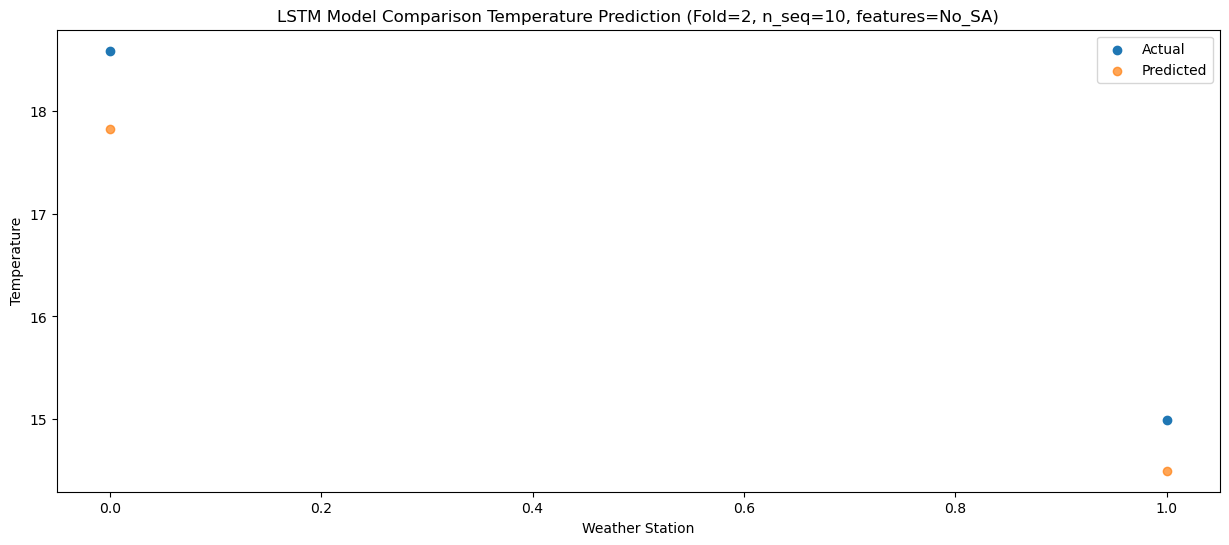

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.31274262 12.98274262]
 [17.1676149  13.8376149 ]
 [18.26673099 14.93673099]
 [18.18186748 14.85186748]
 [17.38159173 14.05159173]
 [17.47579881 14.14579881]
 [17.92594996 14.59594996]
 [17.79130229 14.46130229]
 [17.50153827 14.17153827]
 [17.82626471 14.49626471]]
Year at t+1:
t+1 SKRMSE: 0.476358
t+1 KRMSE: 0.476358
t+1 MAE: 0.380000
t+1 SKMAPE: 0.023246
t+1 R2_SCORE: 0.945740
t+1 KMAPE: 0.023246
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.761164
t+2 KRMSE: 0.761164
t+2 MAE: 0.697385
t+2 SKMAPE: 0.041371
t+2 R2_SCORE: 0.850712
t+2 KMAPE: 0.041371
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.330621
t+3 KRMSE: 0.330621
t+3 MAE: 0.263269
t+3 SKMAPE: 0.014476
t+3 R2_SCORE: 0.968573
t+3 KMAPE: 0.014476
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.233116
t+4 KRMSE: 0.233116
t+4 MAE: 0.180000
t+4 SKMAPE: 0.009939
t+4 R

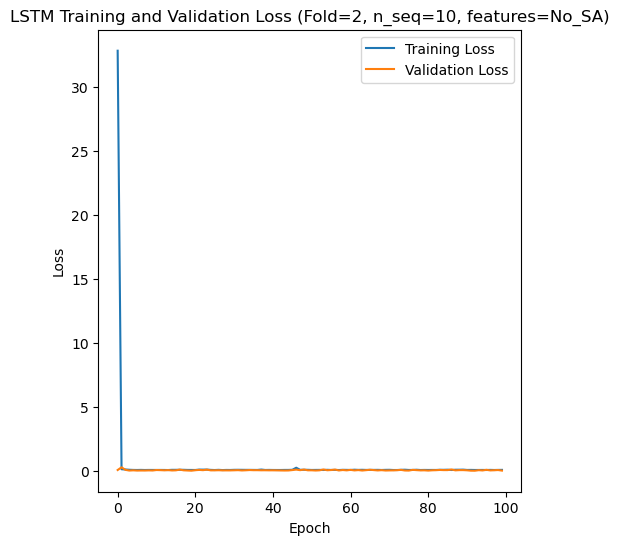

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 6s 80ms/step - loss: 29.0092 - accuracy: 0.0500 - mae: 28.1366 - rmse: 29.0092 - mape: 4415.3540 - pearson: 0.1411 - val_loss: 0.3949 - val_accuracy: 0.0000e+00 - val_mae: 0.3511 - val_rmse: 0.3949 - val_mape: 49.7112 - val_pearson: 0.0010
Epoch 2/100
20/20 [==============================] - 0s 16ms/step - loss: 0.3932 - accuracy: 0.2000 - mae: 0.3413 - rmse: 0.3932 - mape: 54.2594 - pearson: 0.2042 - val_loss: 0.1107 - val_accuracy: 0.0000e+00 - val_mae: 0.0955 - val_rmse: 0.1107 - val_mape: 16.0945 - val_pearson: 0.7754
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1026 -

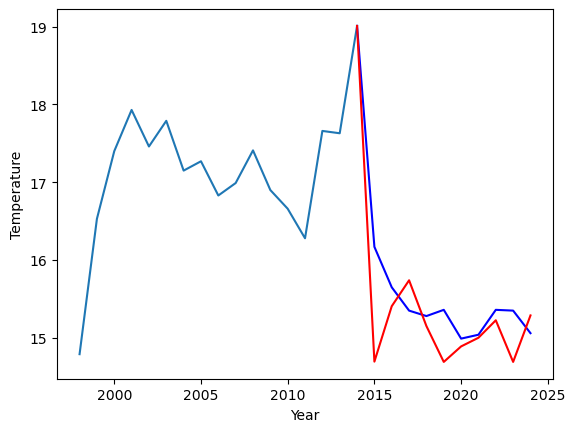

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.96		0.93
14.13		14.68		0.55
15.42		15.01		-0.41
15.25		14.42		-0.83
14.76		13.96		-0.80
15.17		14.16		-1.01
15.05		14.27		-0.78
14.85		14.50		-0.35
14.55		13.96		-0.59
15.57		14.56		-1.01


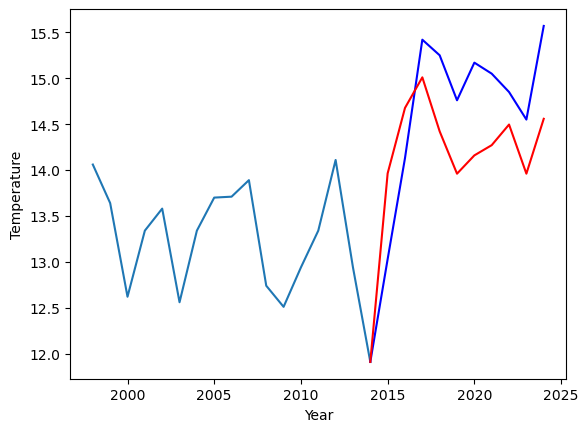

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.694036
1                1   13.03  13.964036


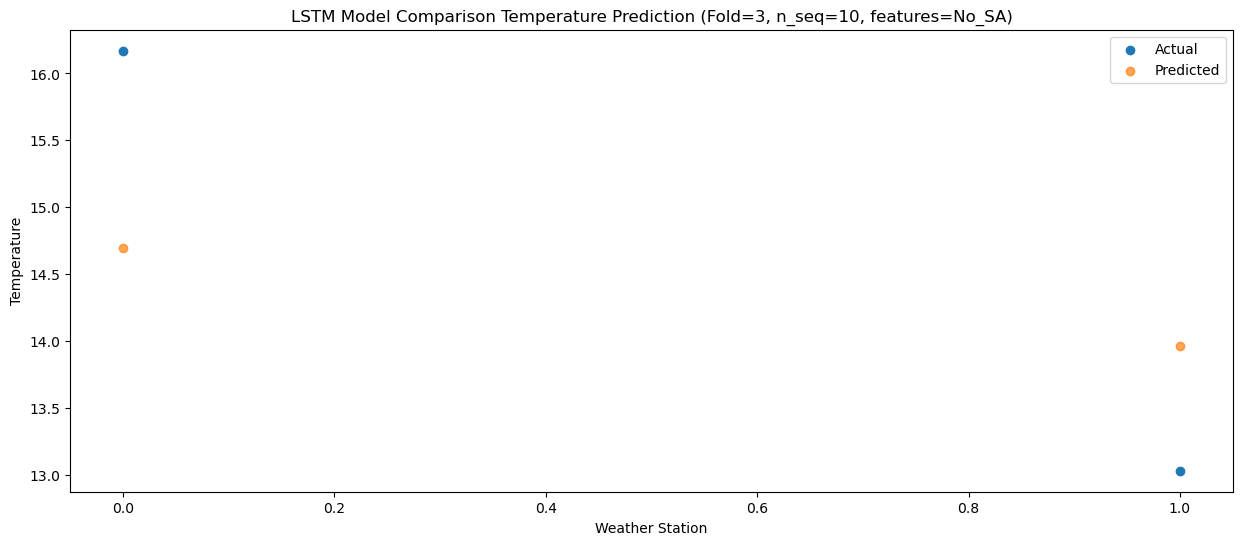

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.406666
1                1   14.13  14.676666


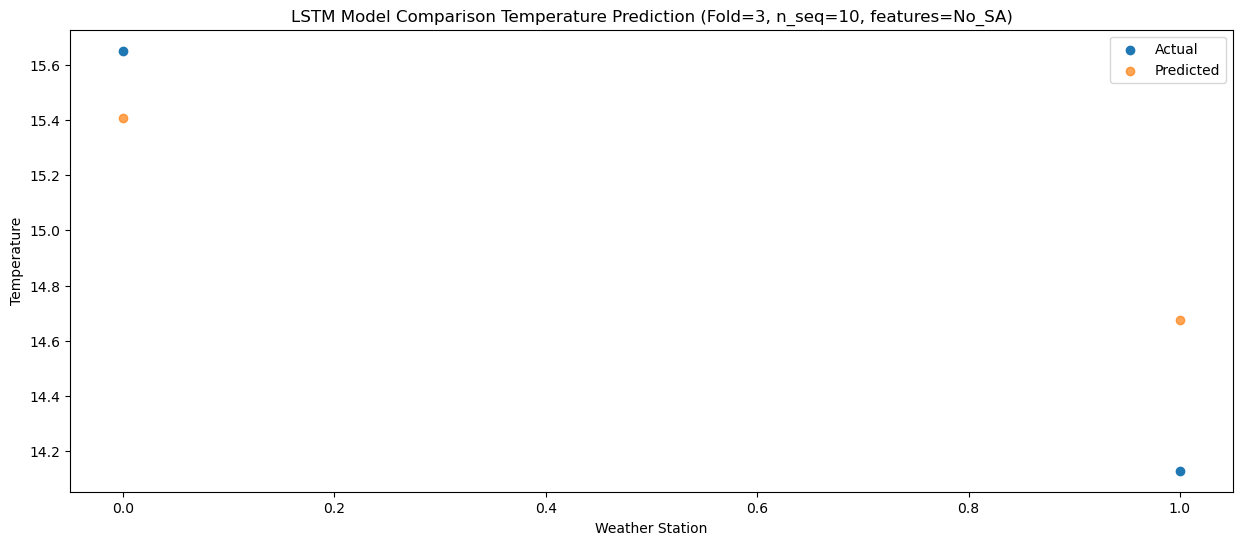

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  15.739886
1                1   15.42  15.009886


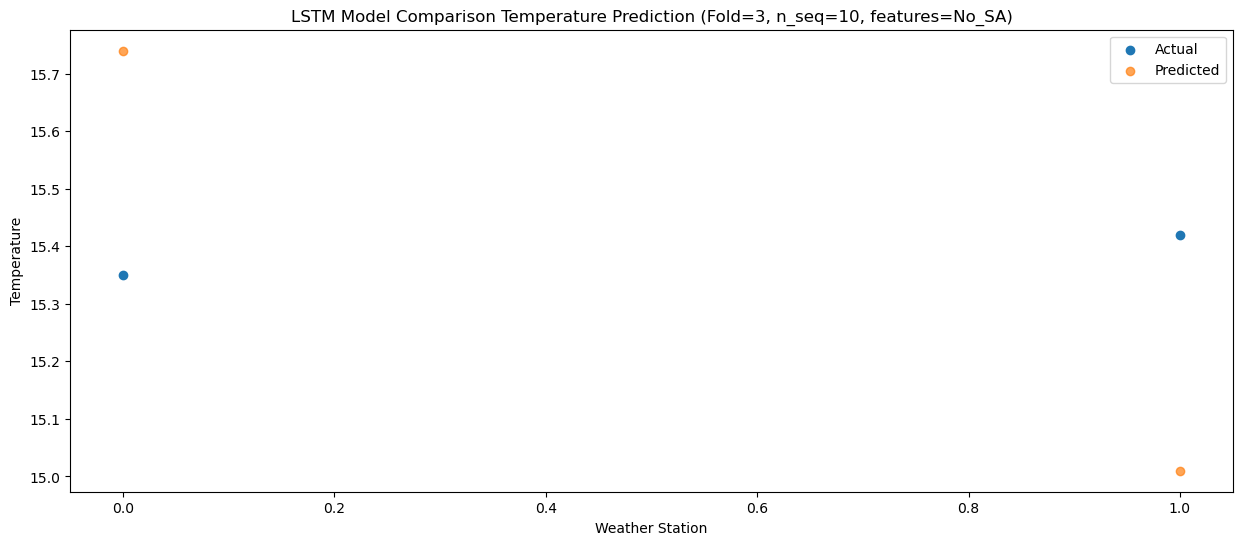

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  15.151128
1                1   15.25  14.421128


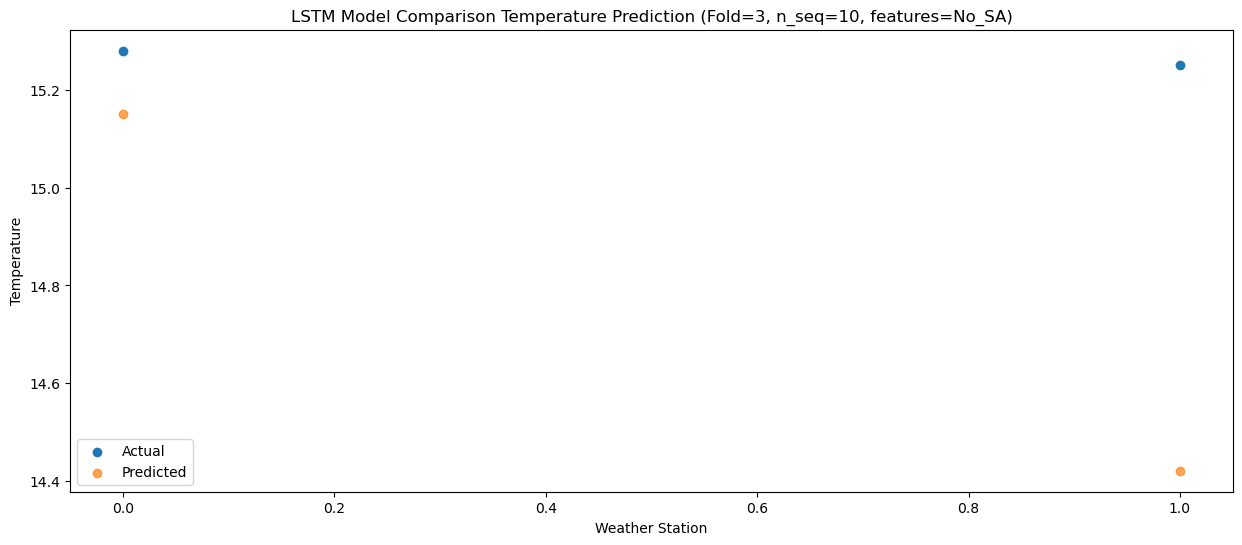

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  14.690402
1                1   14.76  13.960402


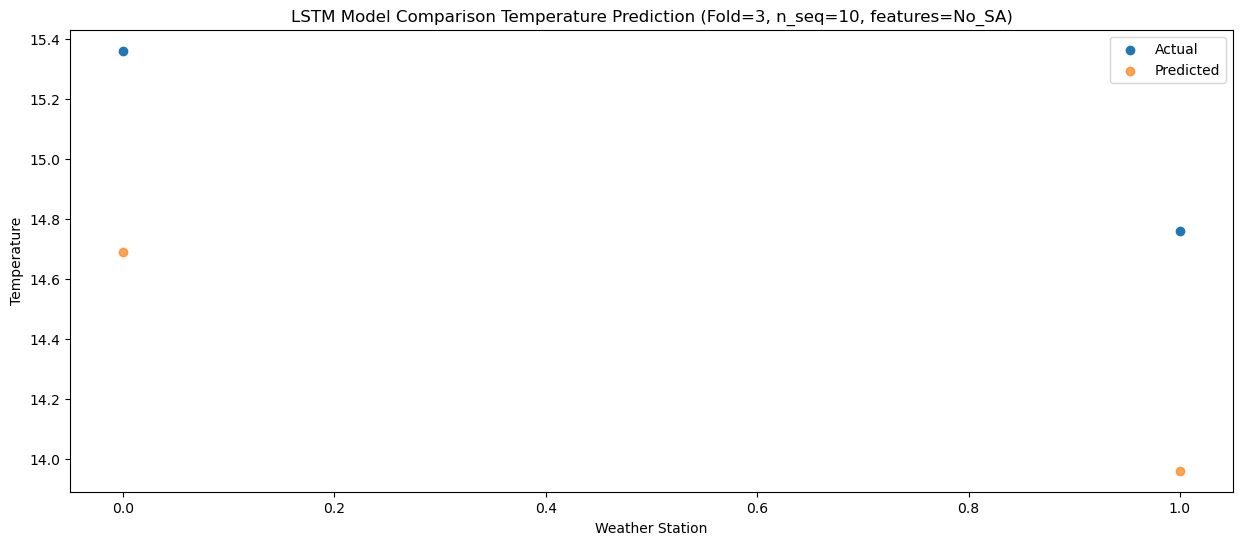

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  14.889781
1                1   15.17  14.159781


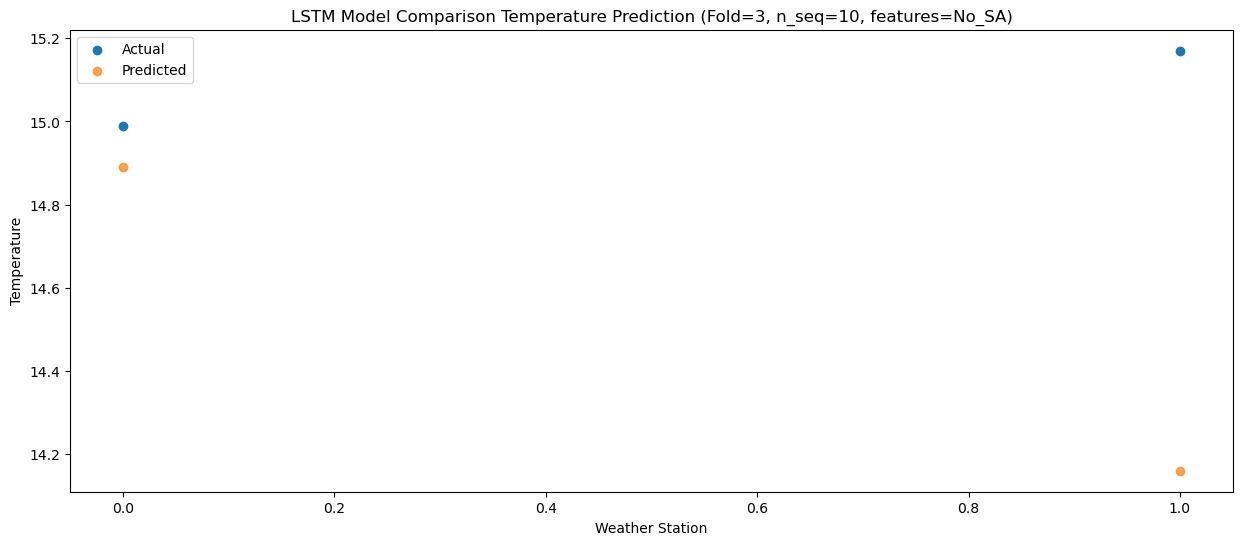

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  15.001154
1                1   15.05  14.271154


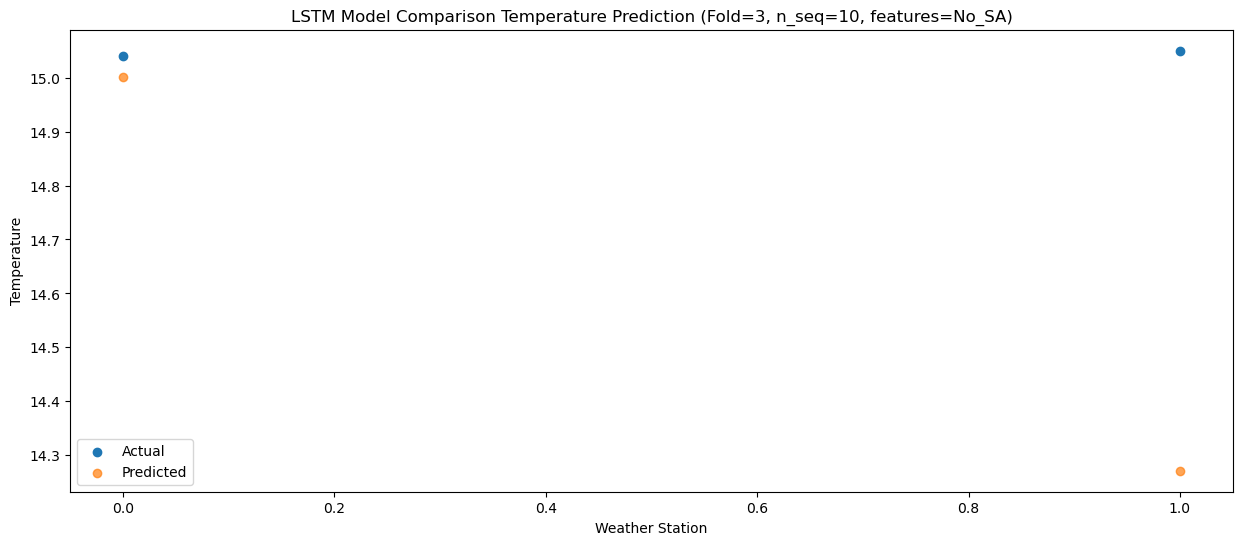

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  15.225818
1                1   14.85  14.495818


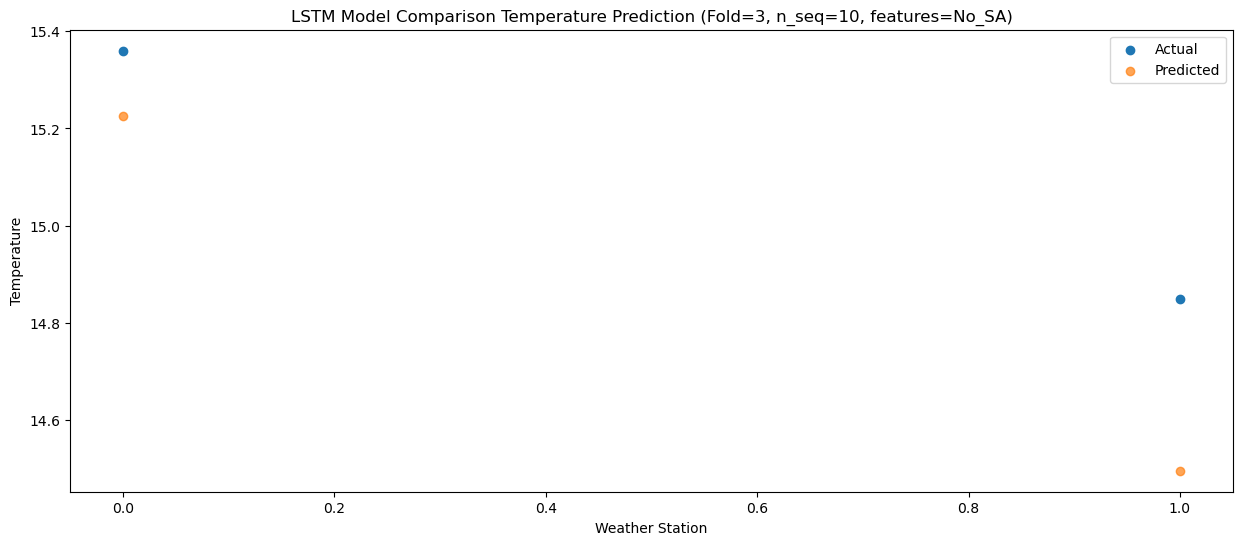

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  14.690553
1                1   14.55  13.960553


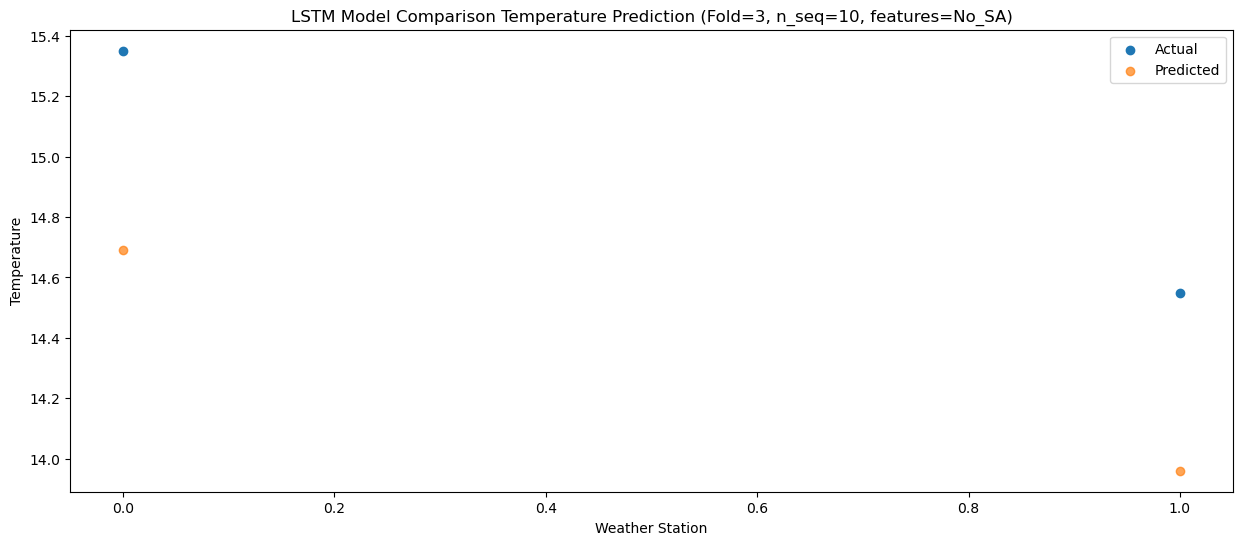

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  15.288318
1                1   15.57  14.558318


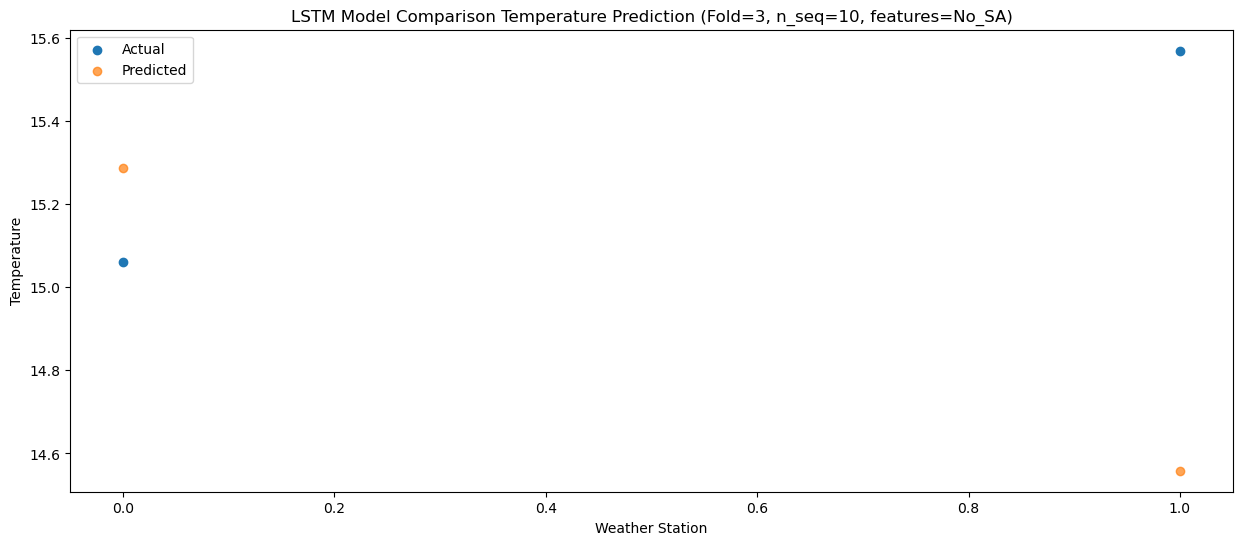

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.6940363  13.9640363 ]
 [15.40666639 14.67666639]
 [15.7398855  15.0098855 ]
 [15.15112817 14.42112817]
 [14.69040188 13.96040188]
 [14.88978102 14.15978102]
 [15.00115406 14.27115406]
 [15.22581776 14.49581776]
 [14.69055262 13.96055262]
 [15.28831818 14.55831818]]
Year at t+1:
t+1 SKRMSE: 1.235090
t+1 KRMSE: 1.235090
t+1 MAE: 1.205000
t+1 SKMAPE: 0.081481
t+1 R2_SCORE: 0.381133
t+1 KMAPE: 0.081481
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.423117
t+2 KRMSE: 0.423117
t+2 MAE: 0.395000
t+2 SKMAPE: 0.027118
t+2 R2_SCORE: 0.690049
t+2 KMAPE: 0.027118
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.400128
t+3 KRMSE: 0.400128
t+3 MAE: 0.400000
t+3 SKMAPE: 0.025998
t+3 R2_SCORE: -129.695758
t+3 KMAPE: 0.025998
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.593143
t+4 KRMSE: 0.593143
t+4 MAE: 0.478872
t+4 SKMAPE: 0.031393
t+

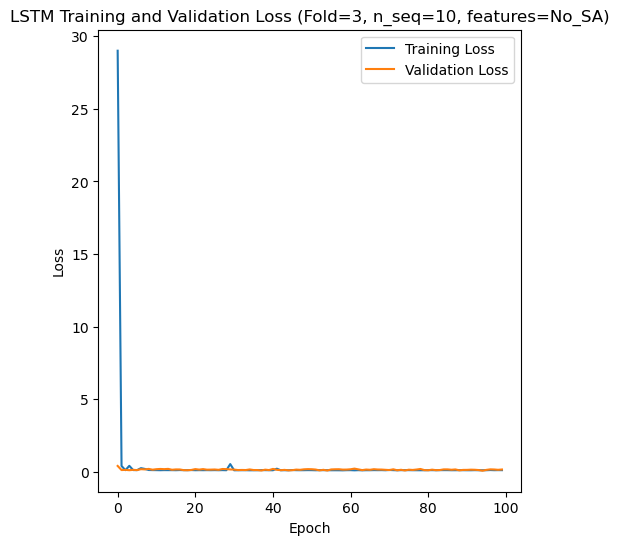

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 6s 104ms/step - loss: 47.8410 - accuracy: 0.2105 - mae: 44.1697 - rmse: 47.8410 - mape: 7311.8584 - pearson: 0.0850 - val_loss: 0.4836 - val_accuracy: 0.0000e+00 - val_mae: 0.4530 - val_rmse: 0.4836 - val_mape: 72.8290 - val_pearson: 0.1622
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5396 - accuracy: 0.3158 - mae: 0.4838 - rmse: 0.5396 - mape: 79.0253 - pearson: 0.2088 - val_loss: 0.2075 - val_accuracy: 0.0000e+00 - val_mae: 0.1637 - val_rmse: 0.2075 - val_mape: 24.1571 - val_pearson: 0.2756
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.418

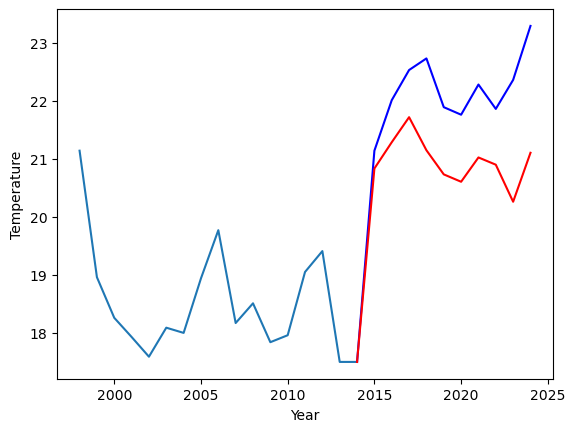

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.62		-0.01
14.58		13.08		-1.50
15.60		13.51		-2.09
15.53		12.94		-2.59
14.23		12.52		-1.71
13.53		12.39		-1.14
14.09		12.81		-1.28
14.41		12.69		-1.72
13.54		12.05		-1.49
15.02		12.89		-2.13


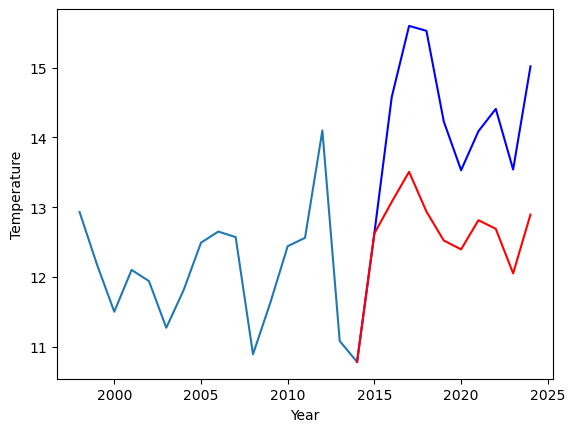

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.833051
1                1   12.63  12.623051


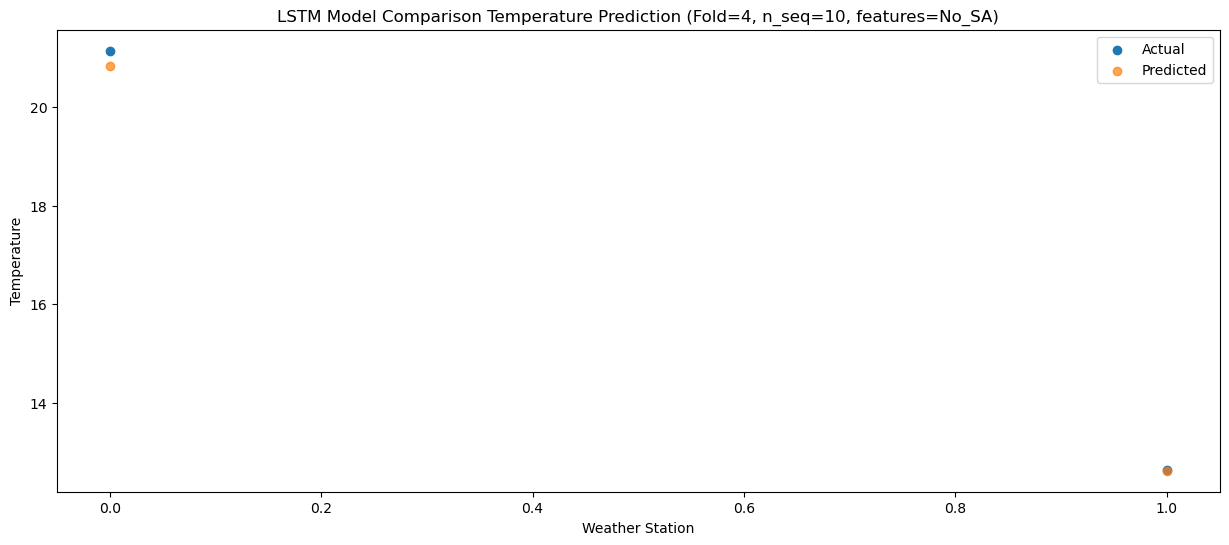

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.285395
1                1   14.58  13.075395


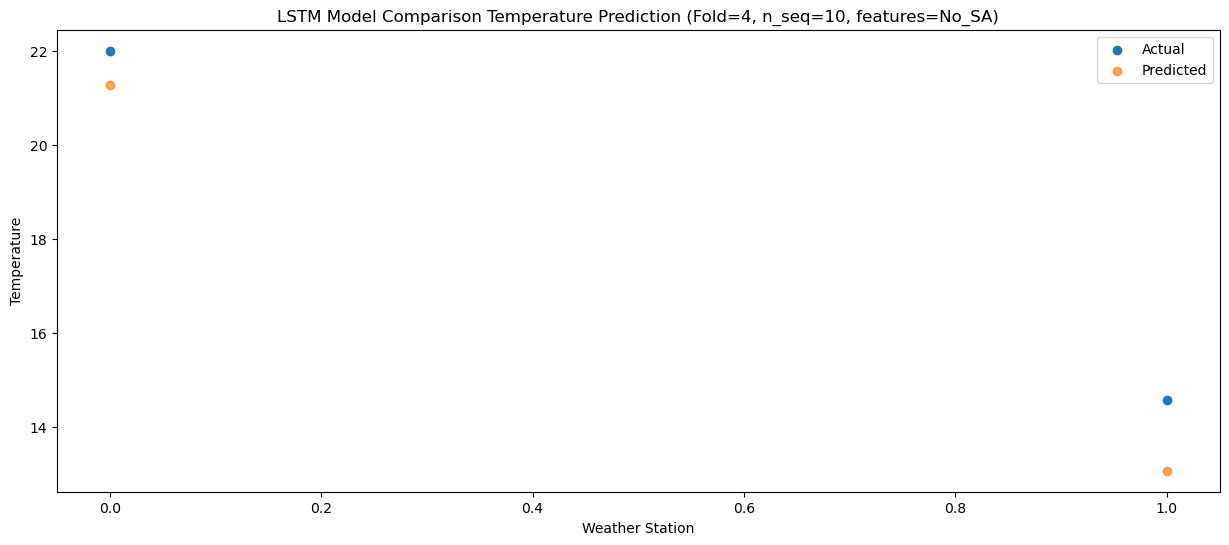

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53   21.71719
1                1   15.60   13.50719


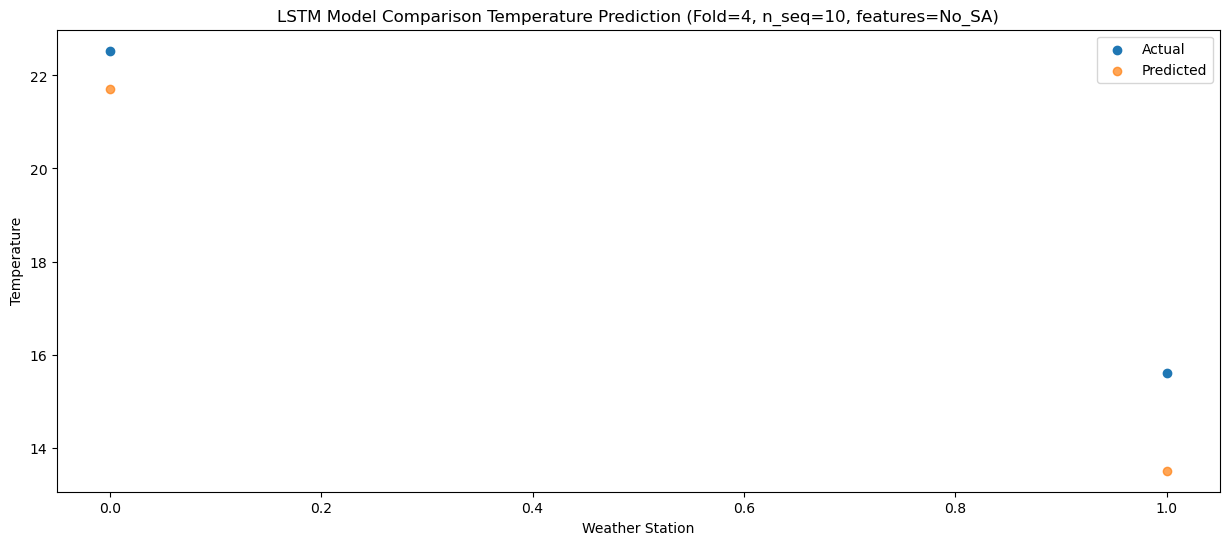

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  21.147583
1                1   15.53  12.937583


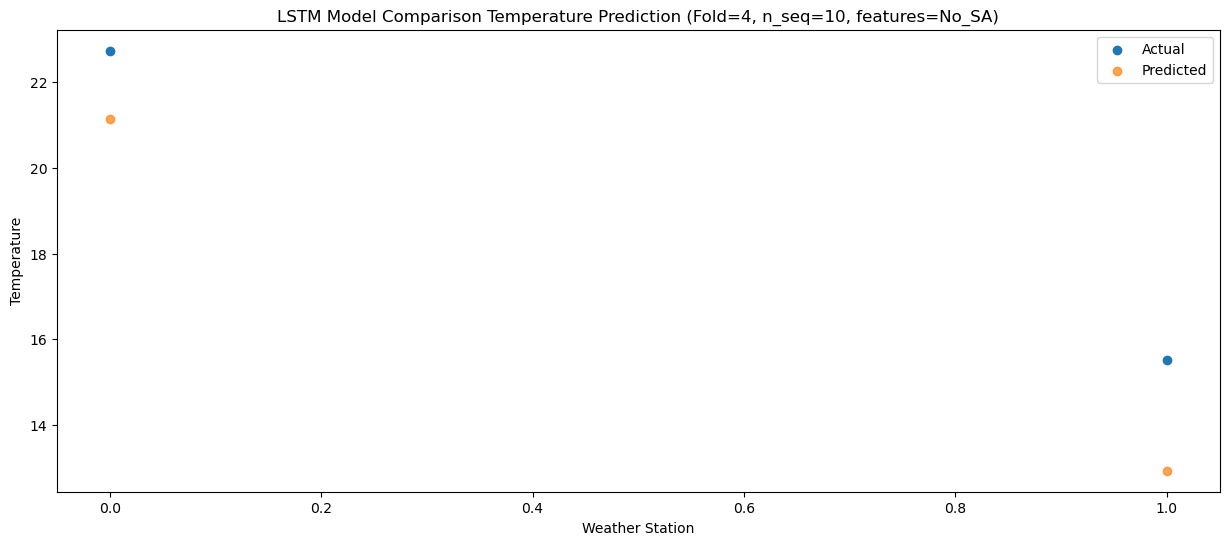

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89   20.73168
1                1   14.23   12.52168


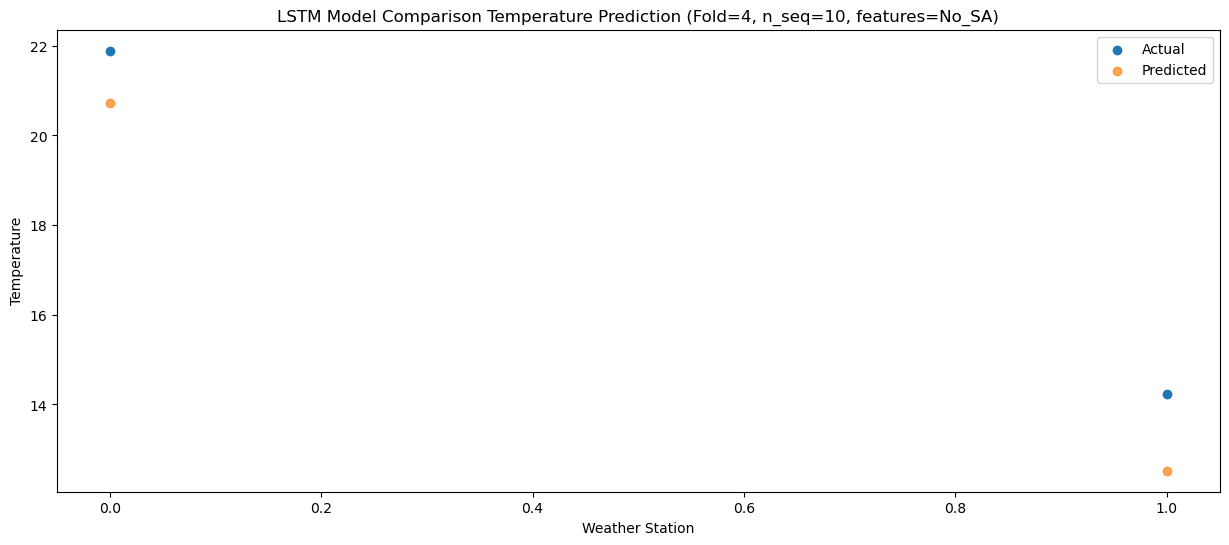

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  20.604596
1                1   13.53  12.394596


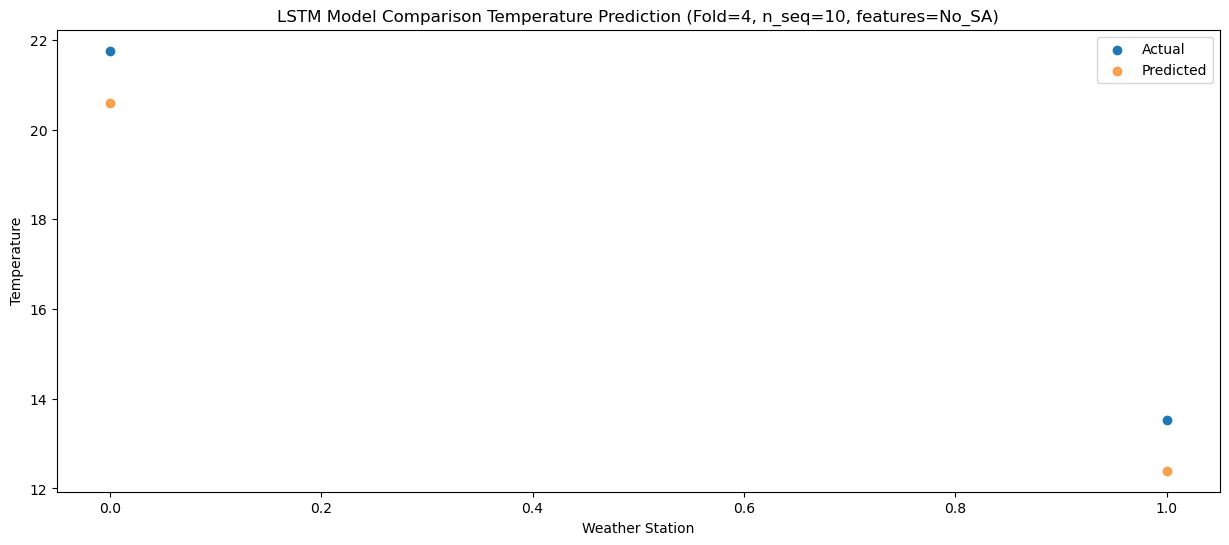

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28   21.02338
1                1   14.09   12.81338


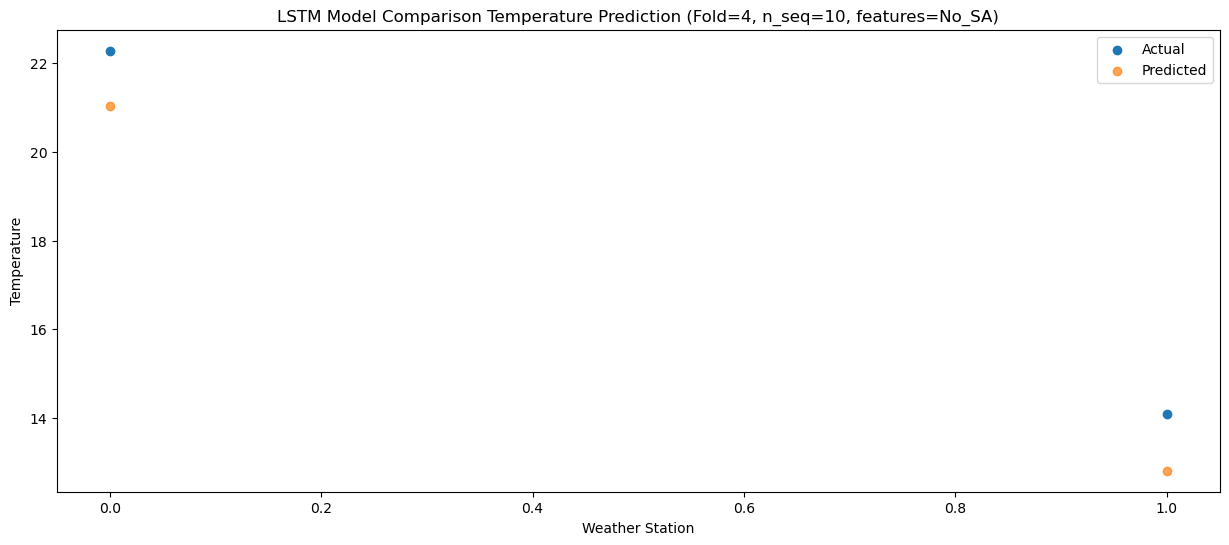

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  20.898722
1                1   14.41  12.688722


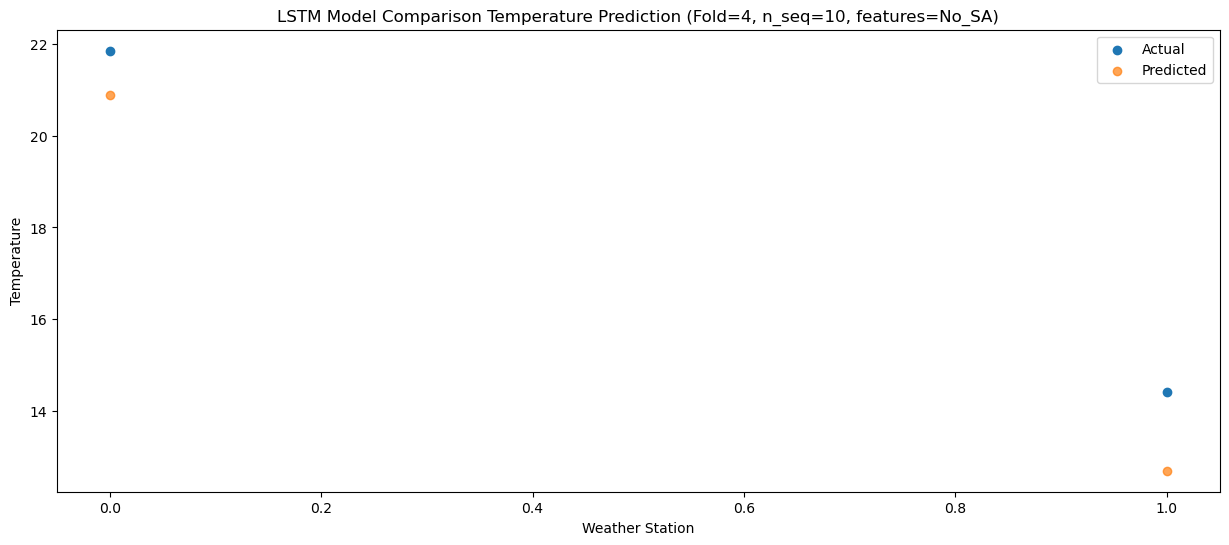

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  20.260146
1                1   13.54  12.050146


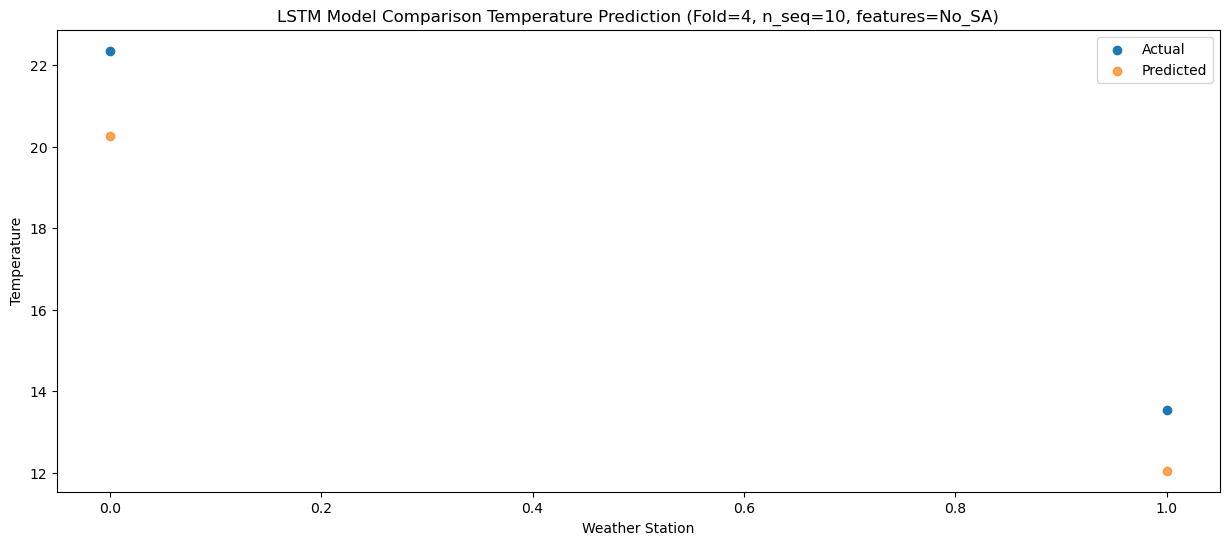

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  21.104014
1                1   15.02  12.894014


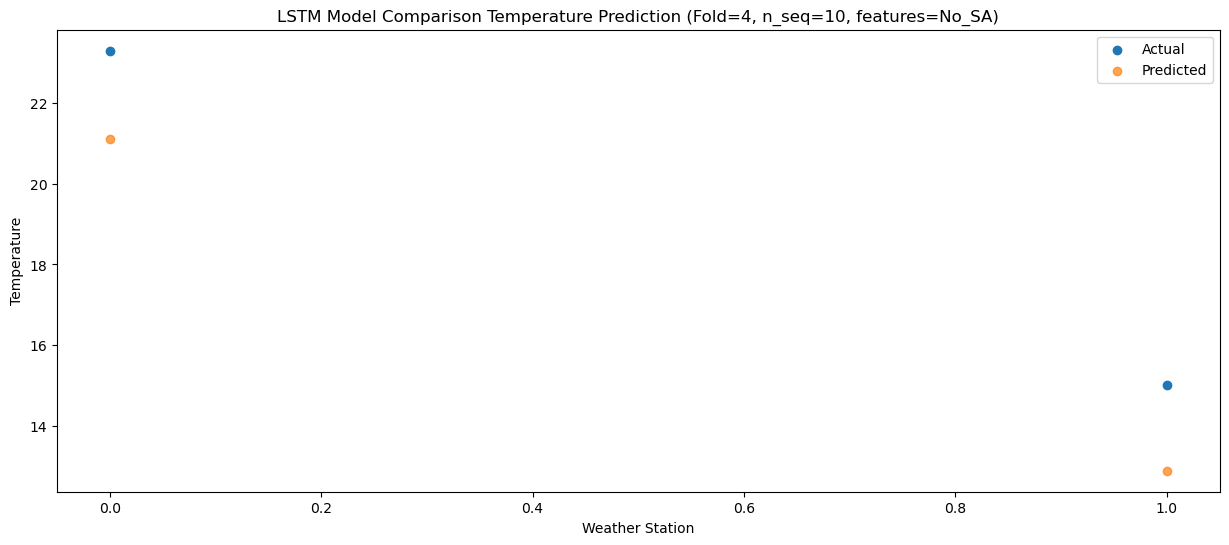

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.8330514  12.6230514 ]
 [21.28539504 13.07539504]
 [21.71719004 13.50719004]
 [21.14758284 12.93758284]
 [20.73167993 12.52167993]
 [20.60459585 12.39459585]
 [21.0233802  12.8133802 ]
 [20.89872151 12.68872151]
 [20.26014649 12.05014649]
 [21.10401433 12.89401433]]
Year at t+1:
t+1 SKRMSE: 0.217101
t+1 KRMSE: 0.217101
t+1 MAE: 0.156949
t+1 SKMAPE: 0.007535
t+1 R2_SCORE: 0.997397
t+1 KMAPE: 0.007535
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.180866
t+2 KRMSE: 1.180866
t+2 MAE: 1.114605
t+2 SKMAPE: 0.068059
t+2 R2_SCORE: 0.898962
t+2 KMAPE: 0.068059
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.587532
t+3 KRMSE: 1.587532
t+3 MAE: 1.452810
t+3 SKMAPE: 0.085116
t+3 R2_SCORE: 0.790087
t+3 KMAPE: 0.085116
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 2.147635
t+4 KRMSE: 2.147635
t+4 MAE: 2.087417
t+4 SKMAPE: 0.118274
t+4 R

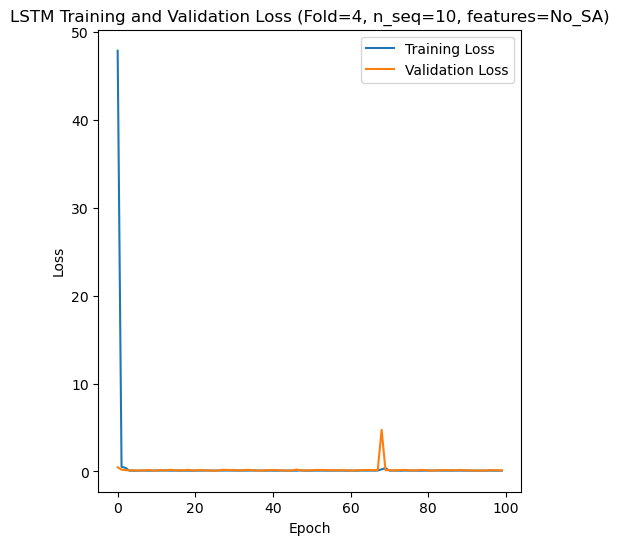

[[0.6147600654574391], [0.7947780462180566], [0.5178176860005311], [0.6767792276067264], [1.5338775489583896]]
[[array(0.61476007)], [array(0.79477805)], [array(0.51781769)], [array(0.67677923)], [array(1.53387755)]]
[[0.4962722413688887], [0.5470208344310523], [0.40732083344459574], [0.566616449952126], [1.3949242359697818]]
[[0.0259890683130317], [0.026930466763634985], [0.023904898152929992], [0.03767778835509246], [0.08088632262026535]]
[[0.9102867822754505], [-1.8067331808536125], [0.9287825603270354], [-0.17469298845441794], [0.8532246417288023]]
[[array(0.02598907)], [array(0.02693047)], [array(0.0239049)], [array(0.03767779)], [array(0.08088632)]]
[[array(0.95967911)], [array(0.00230837)], [array(0.97778169)], [array(0.24140261)], [array(0.97633669)]]
[[[20.14244743824005, 20.976555194854736, 21.96844580411911, 22.223399665355682, 21.42497381210327, 21.714562859535217, 21.669066421836614, 21.31995939478278, 21.21139570340514, 22.419899426549673], [15.872447438240052, 16.7065551

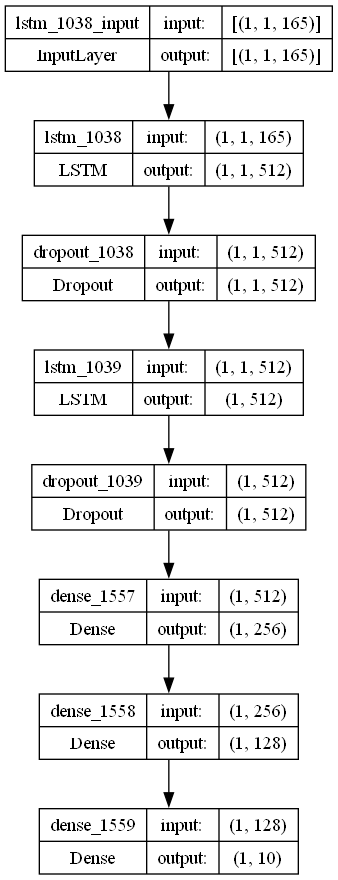

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.1128132002977487
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.331205459175022

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S10_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [8]:
print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

[[0.6147600654574391], [0.7947780462180566], [0.5178176860005311], [0.6767792276067264], [1.5338775489583896]]
[[array(0.61476007)], [array(0.79477805)], [array(0.51781769)], [array(0.67677923)], [array(1.53387755)]]
[[0.4962722413688887], [0.5470208344310523], [0.40732083344459574], [0.566616449952126], [1.3949242359697818]]
[[0.0259890683130317], [0.026930466763634985], [0.023904898152929992], [0.03767778835509246], [0.08088632262026535]]
[[0.9102867822754505], [-1.8067331808536125], [0.9287825603270354], [-0.17469298845441794], [0.8532246417288023]]
[[array(0.02598907)], [array(0.02693047)], [array(0.0239049)], [array(0.03767779)], [array(0.08088632)]]
[[array(0.95967911)], [array(0.00230837)], [array(0.97778169)], [array(0.24140261)], [array(0.97633669)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 20.2